
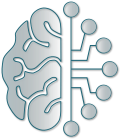

**Start at:** Thursday 02 October 2025, 13:41:07  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, fg, bg, hl
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

#cancel the "last show-up" behaviour of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# 2D Convolutional Neural Networks (CNN)

<div class="intro">
 
    
This notebook introduces the fundamental concepts of **2D Convolutional Neural Networks (CNNs)**, a central class of deep learning models for image analysis. CNNs are widely used in computer vision tasks such as image classification, object detection, and pattern recognition, because they can automatically extract and learn relevant features from raw image data.

We begin by exploring how images are represented as numerical arrays, and how convolutional filters (also called kernels or windows) operate on them. Simple examples illustrate how filters can detect patterns such as edges or smooth regions by scanning the image and combining pixel intensities in a systematic way.

Throughout the notebook, we provide:
- practical functions to visualize images, their histograms, and the effect of convolution,
- hands-on demonstrations of how convolution acts as a derivative or a smoothing operator,
- a progressive introduction to the building blocks of a CNN.

The objective is to develop an intuitive and practical understanding of convolution in 2D, preparing the ground for applying CNNs to real-world image datasets.

   
**Authors: I. C. Gerber, L. Poteau and R. Poteau**
</div>

## Introduction

<div class="intro">

The convolutional layer computes the convolutional operation of the input images using filters to extract features and scans the entire image looking through this filter

**Filters** are also sometimes called **windows**, or **kernels**. 
</div>

<div class="rq">

`imread` of matplotlib returns the image data as a `numpy.array`, which shape is

- (M, N) for grayscale images.

- (M, N, 3) for RGB images.

- (M, N, 4) for RGBA images.

PNG images are returned as float arrays (0-1). All other formats are returned as int arrays
</div>

### Useful functions

In [2]:
def plotimgs_SideBySide(img, imgW=8, titles=None, histogram=True):
    from matplotlib import pyplot as plt
    from skimage import exposure
    import numpy as np

    nPixH, nPixW = img[0].shape
    print(f"W: {nPixW} pixels x H: {nPixH} pixels = {nPixW*nPixH} pixels")

    def plotHisto(img, nplotsAxis0, nplotsAxis1, index):
        plt.subplot(nplotsAxis0, nplotsAxis1, index)
        plt.hist(img.ravel(), bins=256, histtype='step', color='black', label="histogram")
        plt.xlabel('Pixel intensity (0:Black ⇾ 1:White)')
        plt.xlim(0,1)
        plt.ylabel('Number of pixels')
        plt.legend()
        # Display cumulative distribution
        ax = plt.gca()
        ax_twinx = ax.twinx() 
        img_cdf, bins = exposure.cumulative_distribution(img, 256)
        ax_twinx.plot(bins, img_cdf, 'r', label="cumulative distribution")
        plt.legend()

    nimg=len(img)

    nplotsAxis1 = nimg
    if histogram:
        nplotsAxis0 = 2
    else:
        nplotsAxis0 = 1

    Wplot = nimg*imgW
    imgH = (nPixH/nPixW)*imgW
    heightHisto = 80*imgH/100
    # print(imgW,imgH)
    plt.figure(figsize=(Wplot, (imgH + heightHisto))) #
    colorTitle = 'black'
    for i in range(nimg):
        plt.subplot(nplotsAxis0, nplotsAxis1, i+1) # the third argument represents the index of the subplot that will be used
        plt.imshow(img[i], cmap="gray", interpolation="nearest") 
        plt.axis('off')
        plt.title(titles[i],color=colorTitle)
    
        if histogram:
            plotHisto(img[i], nplotsAxis0, nplotsAxis1, (nimg+i+1))
    plt.subplots_adjust(wspace=0.2, hspace=0.05)
    plt.show()

def kernel2D(N):
    import numpy as np
    K = np.ones((N,N),dtype=np.float64)/(N**2)
    return K


### Calculate the "derivatives" of an image

#### First derivative = convolution in 1D

$Ky=[-1,0,1]$

array([229, 230, 214], dtype=uint8)

np.float64(0.8966035294117647)

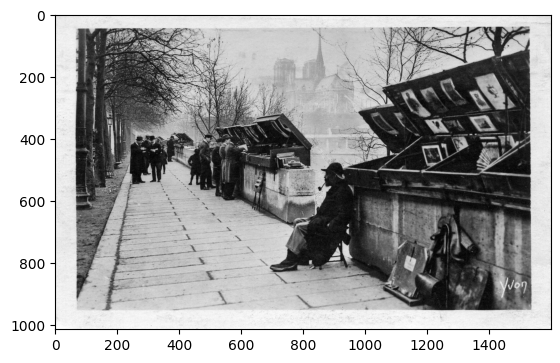

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from scipy.ndimage import convolve, convolve1d

img = plt.imread('./ML-Figures/bouquinistes/bouquinistes.jpg')
display(img[0,0]) #let's have a look at the first pixel
imgGray = rgb2gray(img)
display(imgGray[0,0])
plt.imshow(imgGray, cmap='gray',vmin=0.0, vmax=1.0)

W: 1600 pixels x H: 1014 pixels = 1622400 pixels


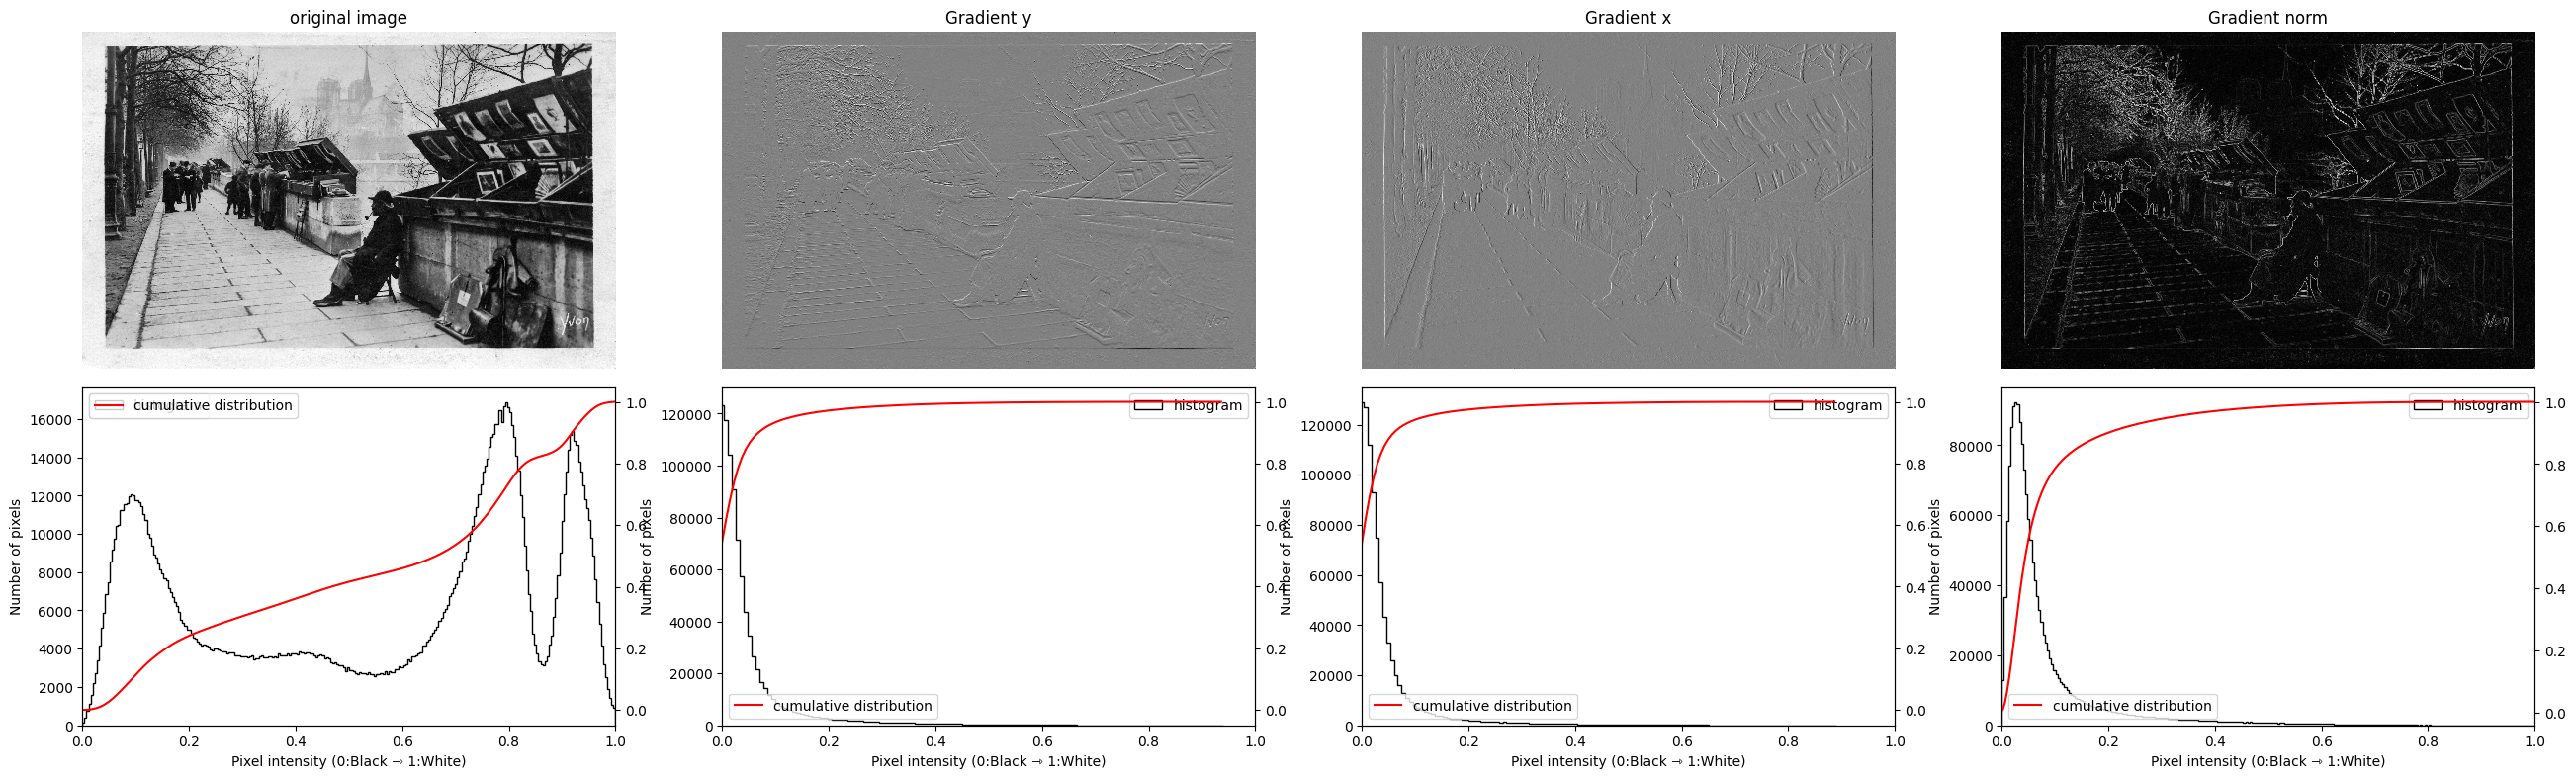

In [4]:
Ky= np.array([-1.,0.,1.])
imgRowAxis = convolve1d(imgGray,Ky,axis=0)
imgColAxis = convolve1d(imgGray,Ky,axis=1)
normGradient = np.sqrt(imgRowAxis**2+imgColAxis**2)

plotimgs_SideBySide([imgGray, imgRowAxis, imgColAxis, normGradient],imgW=8,titles=["original image","Gradient y","Gradient x", "Gradient norm"])

#### Second derivative = convolution in 2D

<div class="intro">

The Laplacian of an image, *i.e.* its "second derivative", highlights the areas of rapid changes in intensity and can thus be used for edge detection. It can be demonstrated that the Laplacian kernel can be formulated as:

$$\left(\begin{array}{ccc}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0
\end{array}\right)$$

It is a second order derivative mask. 
</div>

In [5]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from scipy.ndimage import convolve as cv
img = plt.imread('./ML-Figures/bouquinistes/bouquinistes.jpg')


<div class="rqE">

Yet, the laplacian is very sensitive to noise. We will first start by blurring the image to remove noise.
</div>

In [6]:
Kblur = kernel2D(5)
Kblur
image_blurred = cv(imgGray,Kblur,mode='nearest')

<div class="intro">

The laplacian will now be applied to the blurred image. 
</div>

W: 1600 pixels x H: 1014 pixels = 1622400 pixels


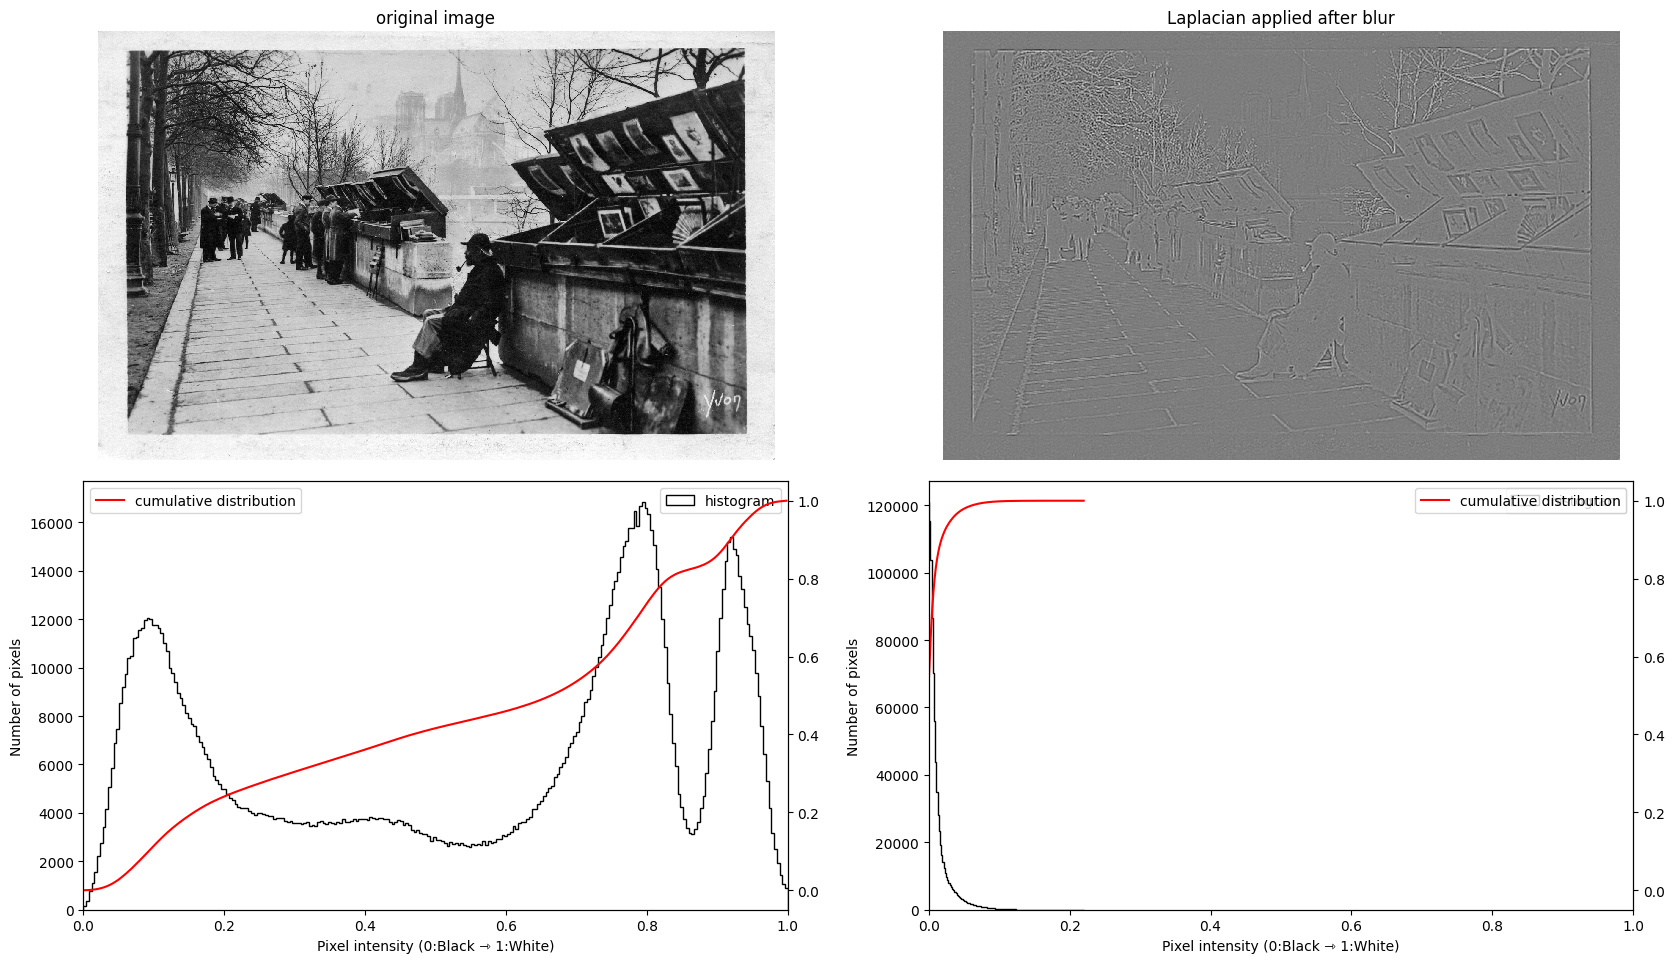

In [7]:
Kcv = np.array([0,1,0,1,-4,1,0,1,0])
Kcv = Kcv.reshape(3,3)
Kcv
image_cv = cv(image_blurred,Kcv,mode='nearest')
plotimgs_SideBySide([imgGray, image_cv],imgW=10,titles=["original image","Laplacian applied after blur"])

### Application: inpainting of an image

<div class="intro">

[Inpainting is a conservation process where damaged, deteriorated, or missing parts of an artwork are filled in to present a complete image](https://en.wikipedia.org/wiki/Inpainting)

From a conventional convolution of the signal *f* with kernel *K*, one would obtain a smoothed one where gaps of missing samples have been filled with the information available, that is: *f\*K*, where * is the convolution operator.

The idea of normalized convolution is that of associating to each signal a **certainty component** expressing the level of confidence in the reliability of each measure of a signal. The **certainty** associated with **missing samples** is equal to **zero**. Therefore we can express the certainty associated with signal *f* as a **map** *c* which has the **same dimension** as *f*. For a 2D image, it will be a 2D array filled with zeros (missing zones) and ones (information available).

The convolution of the certainty map *c* with the smoothing filter *K*, *i.e.* *c\*K* is a weight for the first convolution, which will express the confidence in the results of the conventional convolution.

An approximation of the original signal will be calculated as:

$$\tilde{f}=\frac{f*K}{c*K}$$
</div>

#### Simple example

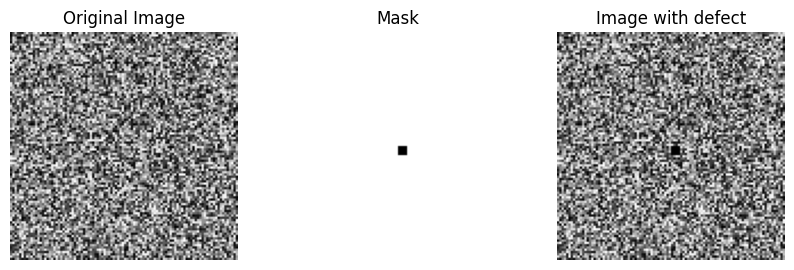

In [8]:
import numpy as np
from scipy.ndimage import convolve

# Example usage
import matplotlib.pyplot as plt

# Create a sample image with a missing region
image = np.random.rand(100, 100)
imageWithDefect = image.copy()
mask = np.ones_like(image)
mask[50:54, 50:54] = 0
booleanMask = mask == 0
imageWithDefect[50:54, 50:54] = 0

# Display the original image and the image with the hole
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray',vmin=0.0, vmax=1.0)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Image with defect')
plt.imshow(imageWithDefect, cmap='gray',vmin=0.0, vmax=1.0)
plt.axis('off')
plt.show()

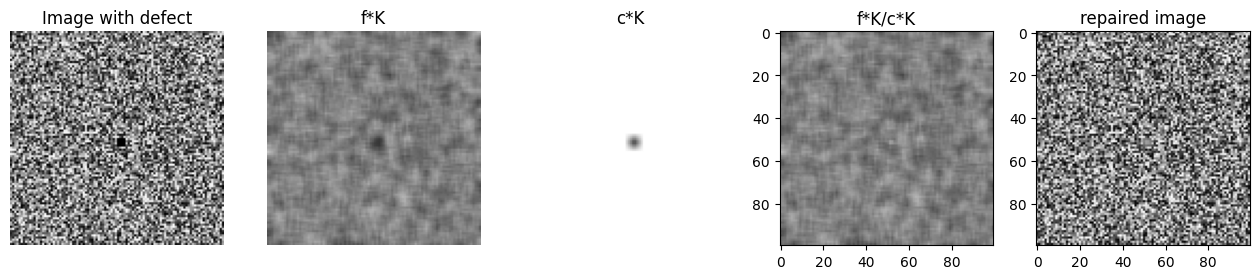

In [9]:
import scipy.ndimage as scnd
import skimage.color as skc
import skimage

# definiton of the kernel K (K must be adapted to the problem)
N = 5
K = np.ones((N,N))*(1/N)**2

# calculation of f*K, where f is the damaged image ")
fK = scnd.convolve(imageWithDefect, K, mode = 'nearest')

# calculation of c*K, where c is the mask
epsilon = 1e-10 #this is to avoid divisions by zero
cK = scnd.convolve(mask + epsilon, K, mode='nearest')

# calculation of f tilde
ftilde = fK/cK

# replacement of the damaged part of the image with ftilde
repaired_image = image.copy()
repaired_image[booleanMask] = ftilde[booleanMask]

# Display the image with the defect, f*K, c*K, ftilde and the final result
plt.figure(figsize=(16, 5))

plt.subplot(1, 5, 1)
plt.title('Image with defect')
plt.imshow(imageWithDefect, cmap='gray',vmin=0.0, vmax=1.0)
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('f*K')
plt.imshow(fK, cmap='gray',vmin=0.0, vmax=1.0)
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('c*K')
plt.imshow(cK, cmap='gray',vmin=0.0, vmax=1.0)
plt.axis('off')

plt.subplot(1, 5, 4)
plt.title('f*K/c*K')
plt.imshow(ftilde,cmap='gray',vmin=0.0, vmax=1.0)

plt.subplot(1, 5, 5)
plt.title('repaired image')
plt.imshow(repaired_image,cmap='gray',vmin=0.0, vmax=1.0)
plt.show()


#### Actual torned image

W: 1331 pixels x H: 1998 pixels = 2659338 pixels


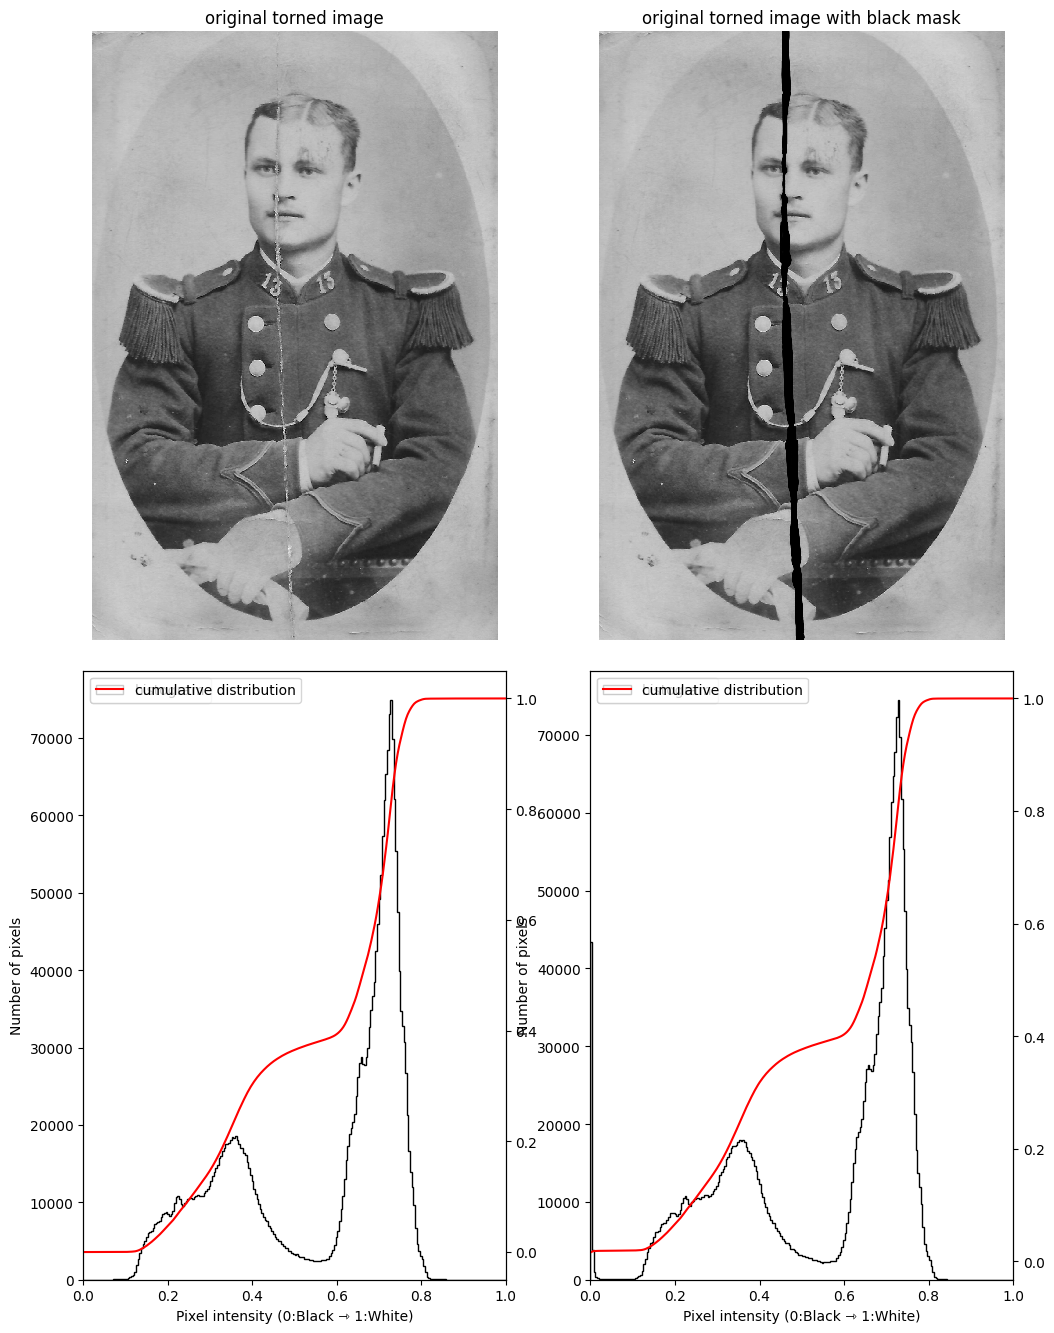

In [10]:
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
import scipy.ndimage as scnd
import skimage.color as skc
import skimage

plt.rcParams['image.cmap'] = 'gray'

imgT = skimage.io.imread('./ML-Figures/Soldier/OldPicture.jpg')
imgTWM = skimage.io.imread('./ML-Figures/Soldier/OldPicture_WithMask.jpg')
# imgT = skimage.io.imread('./ML-Figures/bouquinistes/bouquinistesTorned.jpg')
# imgTWM = skimage.io.imread('./ML-Figures/bouquinistes/bouquinistesTornedWithMask.jpg')

plotimgs_SideBySide([rgb2gray(imgT), rgb2gray(imgTWM)],imgW=6,titles=["original torned image","original torned image with black mask"])

W: 1331 pixels x H: 1998 pixels = 2659338 pixels


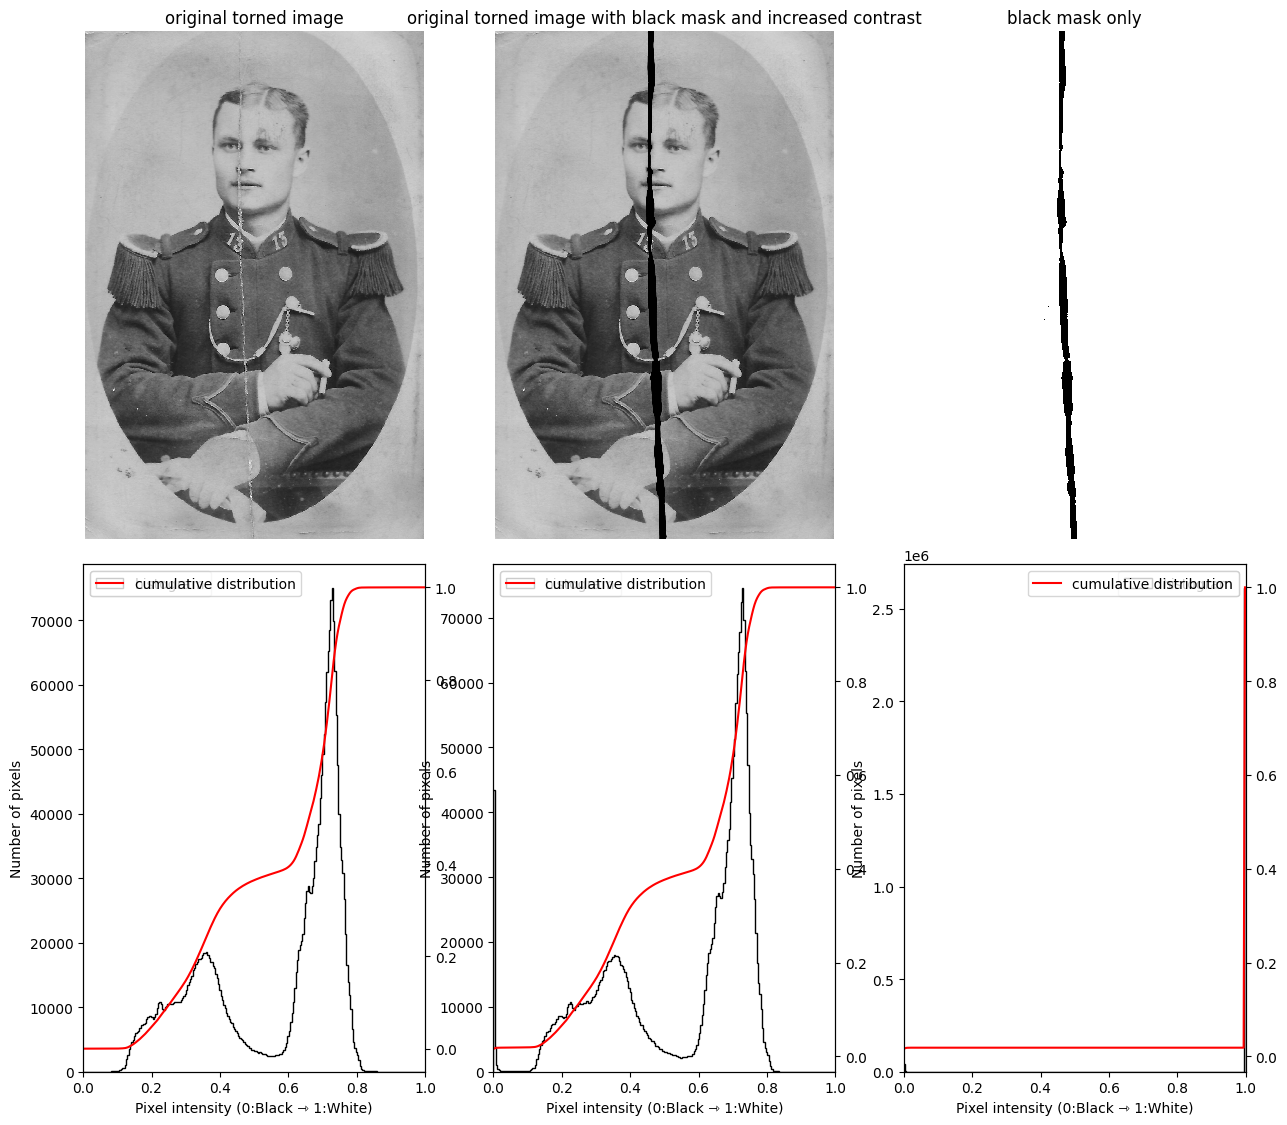

In [11]:
# Threshold to isolate the black mask
threshold = 5

# Create a binary mask
booleanMask = imgTWM < threshold

# Create a white image for the mask
mask = np.ones_like(imgTWM)*255

# replace white pixels of the torned part with black pixels
mask[booleanMask] = imgTWM[booleanMask]

# plots
plotimgs_SideBySide([rgb2gray(imgT), rgb2gray(imgTWM),rgb2gray(mask)],imgW=5,titles=["original torned image","original torned image with black mask and increased contrast","black mask only"])

In [12]:
# definiton of the kernel K (K must be adapted to the problem)
N = 40
K = np.ones((N,N))*(1/N)**2

# calculation of f*K, where f is the damaged image ")
fK = scnd.convolve(rgb2gray(imgTWM), K, mode = 'nearest')

# calculation of c*K, where c is the mask
epsilon = 1e-10 #this is to avoid divisions by zero
cK = scnd.convolve(rgb2gray(mask) + epsilon, K, mode='nearest')

# calculation of f tilde
ftilde = fK/cK

# replacement of the damaged part of the image with ftilde
repaired_image = rgb2gray(imgT.copy())
grayBooleanMask = rgb2gray(mask) <= 0
repaired_image[grayBooleanMask] = ftilde[grayBooleanMask]


W: 1331 pixels x H: 1998 pixels = 2659338 pixels


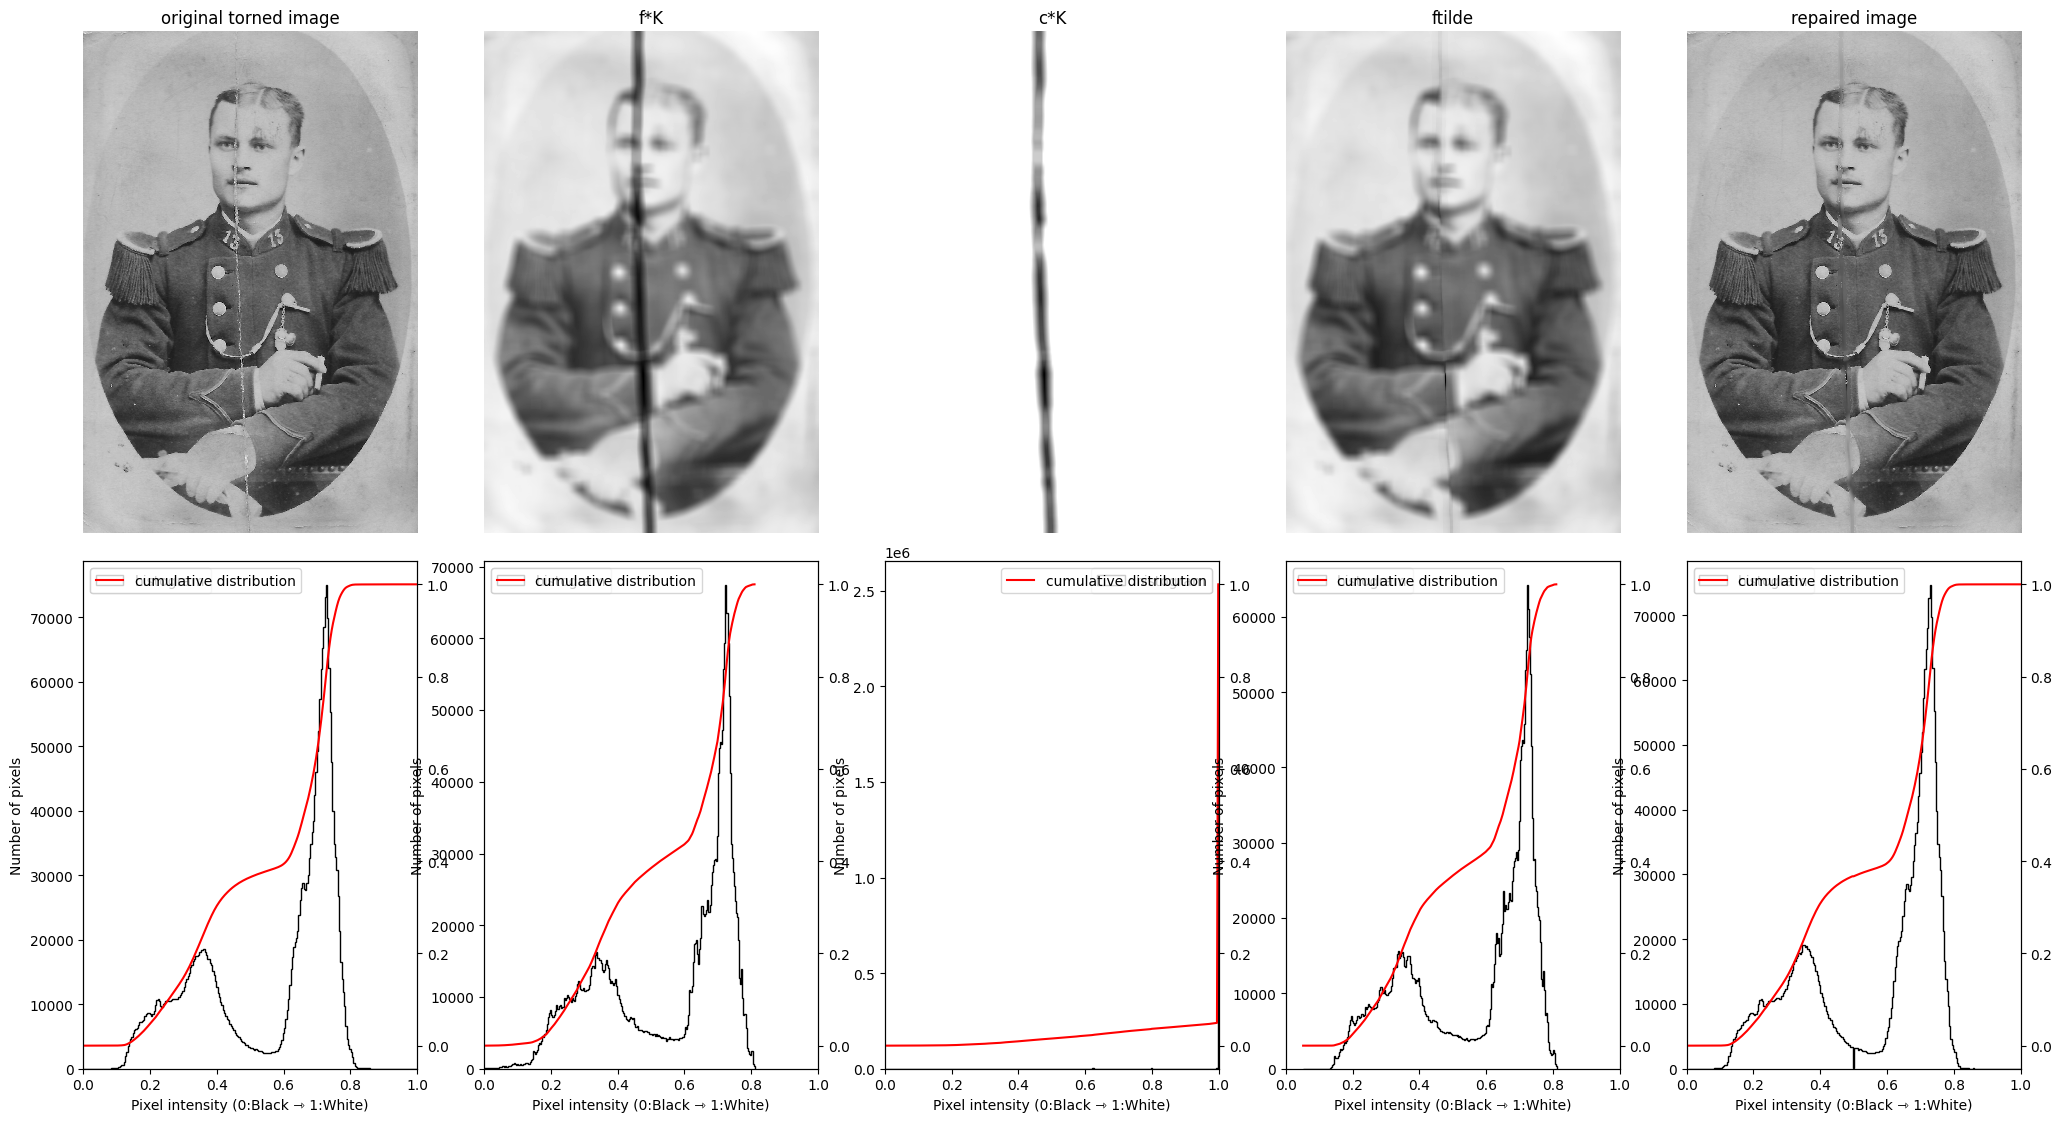

In [13]:
# plots
plotimgs_SideBySide([rgb2gray(imgT), fK, cK, ftilde,repaired_image],imgW=5,titles=["original torned image","f*K","c*K","ftilde","repaired image"])

## Classifying 3 different geometrical shapes

<div class="intro">

In this section, we will put into practice the concepts of 2D convolutional neural networks by tackling a simple but illustrative classification problem. The goal is to train a CNN to distinguish between **three basic geometrical shapes**, namely circles, squares, and triangles, based on their pixel representations.

This **toy example** serves several purposes:
- it provides an accessible and intuitive dataset where the **patterns are easy to interpret**,  
- it illustrates how **convolutional filters** progressively capture shape-specific features,  
- it allows us to test and validate the CNN workflow (data preparation, training, evaluation) on a small and controlled problem before moving to more complex applications,  
- it serves as an analogy to **real research challenges**, such as the recognition and classification of shapes in **TEM or HRTEM images of nanoparticles**, where CNNs can help identify morphological features at the nanoscale.

<figure>
<img width = "800px" src="./ML-Figures/Molecules/AuNPs.png" alt="AuNPs" />

<figcaption> Representative TEM images of Au nanoparticles of different shapes and sizes. (A) Nanospheres. (B) Nanocubes. (C) Nanobranches. (E-F) Nanorods. (G-J) Nanobipyramids. H. Chen <i>et al.</i>, Shape- and Size-Dependent Refractive Index Sensitivity of Gold Nanoparticles (<b>2008</b>), Langmuir <b>24</b>: 5233-5237. <a href="https://dx.doi.org/10.1021/la800305j">10.1021/la800305j</a></figcaption>

</figure> 
<br>

By the end of this section, you should have a clear understanding of **how CNNs can be trained to recognize and classify images**, and how this capability can be extended from simple geometrical patterns to advanced applications in nanoscience.

</div>

### Import stuff

<div class='intro'>

This part of the notebook sets up the Python environment and loads the main libraries required for the classification task. The goal is to prepare all the tools needed for training, evaluating, and visualizing a convolutional neural network (CNN) applied to image data.

The main elements are:
- **Data handling and visualization**: `pandas`, `numpy`, `matplotlib`, `cv2`, and `PIL` are used for managing datasets, processing images, and displaying results.
- **Deep learning framework**: `tensorflow` and `keras` provide the building blocks for defining the CNN architecture, training the model, and applying regularization and callbacks to improve convergence.
- **Image preprocessing**: `ImageDataGenerator` (from Keras) is used to augment and preprocess images before feeding them into the network.
- **Model evaluation**: `scikit-learn` metrics (accuracy, precision, recall, F1 score) and confusion matrices are employed to assess model performance.
- **Training optimization**: callbacks such as `EarlyStopping`, `ModelCheckpoint`, and `ReduceLROnPlateau` help monitor training, prevent overfitting, and automatically adjust the learning rate.

In short, this section prepares all the necessary modules for implementing the CNN pipeline: from data preparation to training, prediction, and evaluation.

</div>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# file management imports
import os  ### only for count of images from dir, can be removed later
import tensorflow as tf
# model imports for deep learning
from keras import Input, layers, models, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import cv2
from sklearn import metrics
#for confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import itertools
from sklearn.metrics import ConfusionMatrixDisplay

#for displaying images when predicting class
from PIL import Image, ImageOps
#for rounding up fitting model for steps_per_epoch
import math

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
#from google.colab import drive

# Ticks stuff for matplotlib
import matplotlib.ticker as mticker

2025-10-01 18:48:46.902688: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-01 18:48:46.905781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 18:48:47.045370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 18:48:48.567527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

### Definition of various functions

<div class="intro">

- `display_image(image_directory)`: 
This function is a simple utility to load and display an image from disk.
It uses Keras’ `image.load_img` to read the image and Matplotlib to show it.
The goal is mainly for manual inspection or verification (e.g., checking whether images are loaded or preprocessed correctly).

- `plot_confusion_matrix(cm, classes, ...)`:
This function creates a visual representation of a confusion matrix after classification.
It can show either the raw counts of predictions per class, or the normalized values (fractions/percentages), if normalize=True.
It highlights each cell with color coding (blue shades), and overlays the numeric values for clarity.
The function helps evaluate how well a classifier is performing, by showing:
    - along the diagonal: the correctly classified samples,
    - off-diagonal: the misclassifications.

</div>

In [15]:
#display image smaller (for checking manually)
def display_image(image_directory):
    im = image.load_img(image_directory)
    fig, ax = plt.subplots(figsize=(10,6))
    # displaying the image with figsize
    ax.imshow(im)

# confusion matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)
    tick_marks = np.arange(len(classes))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Preparation of the Train, Validation and Test Sets

#### Location of the training, validation and test sets

<div class="intro">

The dataset is split into three folders:

- `train/` → images used to train the CNN,
- `val/` → images used to tune hyperparameters and prevent overfitting,
- `test/` → final unseen images used to evaluate the model.

Each subdirectory (inside train/val/test) corresponds to one class (circle, square, triangle).
</div>

In [16]:
train_dir = "./ML-data/ML-CircSquTri/train/"
val_dir = "./ML-data/ML-CircSquTri/val/"
test_dir = "./ML-data/ML-CircSquTri/test/"

#### Batch Size Definition + Image size definition

In [17]:
batch_size = 32
input = Input(shape=(128, 128, 1))

#### Application (or not) of image transformation 

<div class='intro'>

- `ImageDataGenerator` is a Keras utility that prepares images before feeding them to the CNN. `ImageDataGenerator(rescale=1./255.)` rescales pixel values from [0, 255] to [0, 1]
- `flow_from_directory` automatically:
    - Reads images from the given folder,
    - Resizes them to (128, 128),
    - Groups them into batches of 32 (batch_size),
    - Labels them according to the folder they come from,
    - Converts labels into categorical form (one-hot encoded).
    - `color_mode='grayscale'` → the network works with black-and-white images (not RGB).

Training data and validation data are shuffled for learning, test data is not shuffled (to keep a fixed order for evaluation).
</div>

In [18]:
train_image_generator = ImageDataGenerator(rescale=1./255.)
validation_image_generator = ImageDataGenerator(rescale=1./255.)
test_image_generator = ImageDataGenerator(rescale=1./255.)

#making tensorflow for training data
t4pPC.centerTitle("Training set")
training_data = train_image_generator.flow_from_directory(directory= train_dir,       # dataset
                                                   target_size = (128,128),      # desired dimensions for the images
                                                   batch_size = batch_size,    # it will be run in groups of(batch_size specified above)
                                                   class_mode = 'categorical', # type of classifiaction
                                                   #classes=classes, 
                                                   color_mode='grayscale',
                                                   #shuffle=False, 
                                                   )
#making tensorflow for testing data
t4pPC.centerTitle("Validation set")
val_data = validation_image_generator.flow_from_directory(directory= val_dir,
                                                   target_size = (128,128),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   #classes=classes, 
                                                   color_mode='grayscale',
                                                   #shuffle=False 
                                                   )
t4pPC.centerTitle("Test set")
test_data = test_image_generator.flow_from_directory(directory= test_dir,
                                                   target_size = (128,128),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   #classes=classes, 
                                                   color_mode='grayscale',
                                                   shuffle=False 
                                                   )

Found 2005 images belonging to 3 classes.


Found 406 images belonging to 3 classes.


Found 406 images belonging to 3 classes.


In [19]:
print(training_data.class_indices)   # mapping {class_name: integer}
print(len(training_data.classes))
print(training_data.classes)
batch = next(iter(training_data))
print(type(batch))
print(len(batch))  
print(batch[0].shape, batch[1].shape)


{'circle': 0, 'square': 1, 'triangle': 2}
2005
[0 0 0 ... 2 2 2]
<class 'tuple'>
2
(32, 128, 128, 1) (32, 3)


#### Visualization of some shapes of the training set

Class mapping: {'circle': 0, 'square': 1, 'triangle': 2}
['circle', 'square', 'triangle']
✅ Loaded 406 test images across 3 classes.


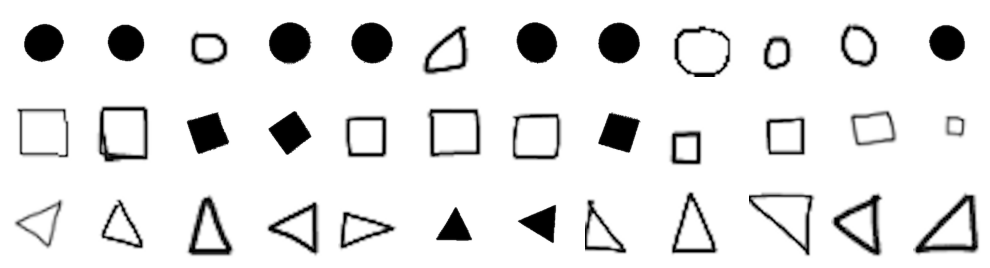

In [20]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 1. Get class mapping from the generator (ensures consistency)
class_indices = test_data.class_indices
print("Class mapping:", class_indices)
# Define classes in the same order as your dataset folders
classes = list(training_data.class_indices.keys())
print(classes)

# Reverse mapping: index → class name
idx_to_class = {v: k for k, v in class_indices.items()}

# 2. Load all test images manually
X_test, y_true, file_paths = [], [], []

for cls, label in class_indices.items():
    cls_dir = os.path.join(test_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.startswith("."):  # skip hidden files like .DS_Store
            continue
        img_path = os.path.join(cls_dir, fname)
        img = image.load_img(img_path, color_mode="grayscale", target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0  # scale to [0,1]
        X_test.append(img_array)
        y_true.append(label)
        file_paths.append(img_path)

X_test = np.array(X_test)
y_true = np.array(y_true)

print(f"✅ Loaded {len(X_test)} test images across {len(class_indices)} classes.")


# Number of images per class to display
n_per_class = 12

fig, axes = plt.subplots(len(classes), n_per_class, figsize=(10, 3))

for row, cls in enumerate(classes):
    class_dir = os.path.join(train_dir, cls)
    files = random.sample(os.listdir(class_dir), n_per_class)  # pick 10 random images
    
    for col, fname in enumerate(files):
        img_path = os.path.join(class_dir, fname)
        img = image.load_img(img_path, color_mode="grayscale", target_size=(128, 128))
        axes[row, col].imshow(img, cmap="gray")
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_ylabel(cls, rotation=0, size="large", labelpad=30)

plt.tight_layout()
plt.show()


### Vanilla Neural Network

#### Model Construction

2025-10-01 18:48:56.911458: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,105,731 (8.03 MB)

 Trainable params: 2,105,731 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

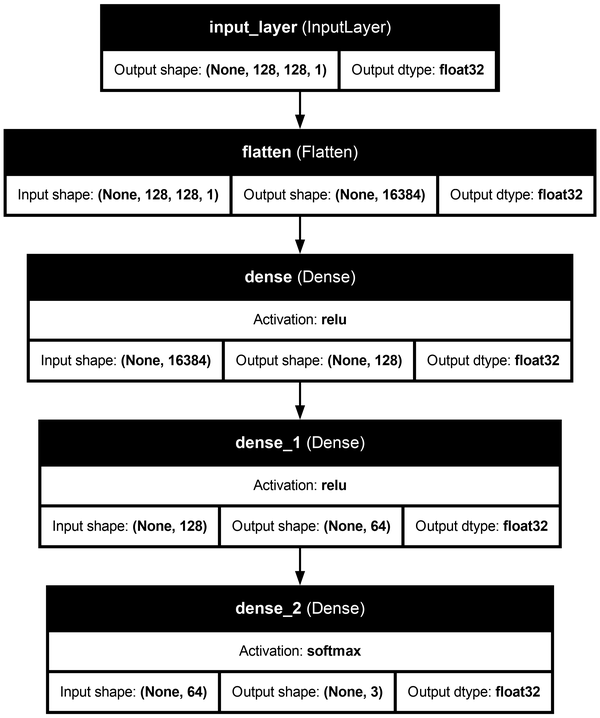

In [21]:
# Resets all state generated by Keras
tf.keras.backend.clear_session()

input = Input(shape=(128, 128, 1))
x = layers.Flatten()(input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)

model = models.Model(input, x)

#from tensorflow.keras.optimizers import SGD
#optimizer = SGD(learning_rate=0.1)
optimizer = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
model.summary()

from tensorflow.keras.utils import plot_model
fig = plot_model(model, dpi=300, show_dtype=True , show_shapes=True, show_layer_names=True, show_layer_activations=True)
t4pPC.displayModel(fig, width = 600)

#### Run for 40 Epochs maximum

In [22]:
nepochs = 40

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',    # you can also use 'val_accuracy'
    patience=10,            # number of epochs with no improvement before stopping
    restore_best_weights=True # roll back to the best model
)

# Train the model with early stopping
history = model.fit(
    training_data,
    validation_data=val_data,
    epochs=nepochs,
    callbacks=[early_stop]
)


Epoch 1/40


/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4953 - loss: 2.2319 - val_accuracy: 0.7340 - val_loss: 1.1958
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6459 - loss: 0.8240 - val_accuracy: 0.7414 - val_loss: 0.6651
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7247 - loss: 0.6673 - val_accuracy: 0.7562 - val_loss: 0.6450
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6489 - loss: 1.0193 - val_accuracy: 0.6281 - val_loss: 0.6973
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7581 - loss: 0.5942 - val_accuracy: 0.7635 - val_loss: 0.5761
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7611 - loss: 0.5784 - val_accuracy: 0.7291 - val_loss: 0.6864
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7287 - loss: 0.6988 - val_accuracy: 0.7241 - val_loss: 0.6676
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7810 - loss: 0.5618 - val_accuracy: 0.7833 - val_loss: 0.

#### Analysis of the Results 

In [23]:
accuracyDNN = history.history['accuracy'][1:]
lossDNN = history.history['loss'][1:]
val_accuracyDNN = history.history['val_accuracy'][1:]
val_lossDNN = history.history['val_loss'][1:]

##### Plot Accuracy and Validation Accuracy curve

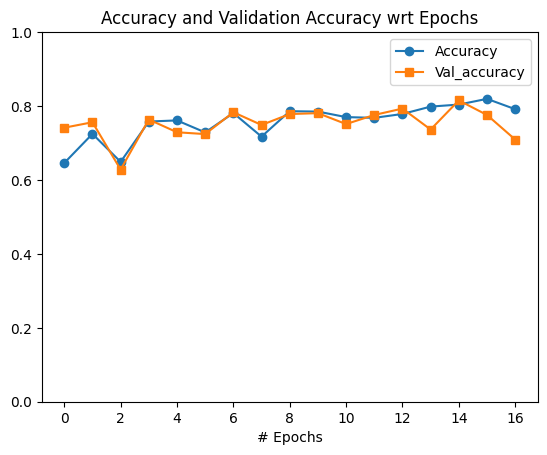

In [24]:
#plot accuracy for model
plt.plot(range(len(accuracyDNN)), accuracyDNN, marker= 'o', label = 'Accuracy')
#plot loss for model
plt.plot(range(len(val_accuracyDNN)), val_accuracyDNN, marker= 's', label = 'Val_accuracy')
plt.xlabel('# Epochs')
plt.ylim(0.,1.00)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
plt.ylabel('')
plt.title('Accuracy and Validation Accuracy wrt Epochs')
plt.legend()

##### Plot Loss and and Validation 

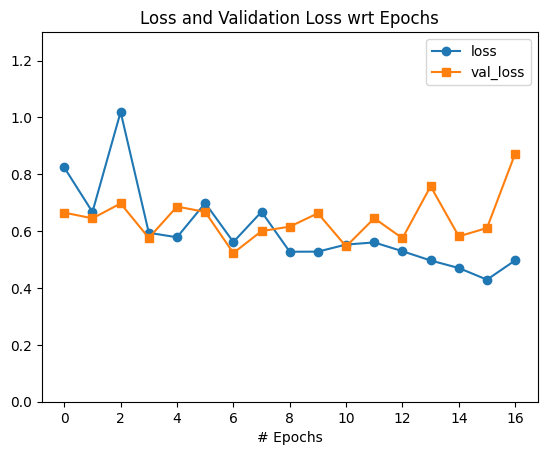

In [25]:
plt.plot(range(len(lossDNN)), lossDNN, marker= 'o', label = 'loss')
#plot loss for model
plt.plot(range(len(val_lossDNN)), val_lossDNN, marker= 's', label = 'val_loss')
plt.xlabel('# Epochs')
plt.ylabel('')
plt.ylim(0.0,1.3)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
plt.title('Loss and Validation Loss wrt Epochs')
plt.legend()

#### Test the Model

##### Prediction

In [26]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
print(class_labels)
print(true_classes)
#test_data
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

['circle', 'square', 'triangle']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


##### Confusion matrix

Normalized confusion matrix
[[0.81102362 0.11811024 0.07086614]
 [0.39230769 0.56923077 0.03846154]
 [0.04697987 0.00671141 0.94630872]]


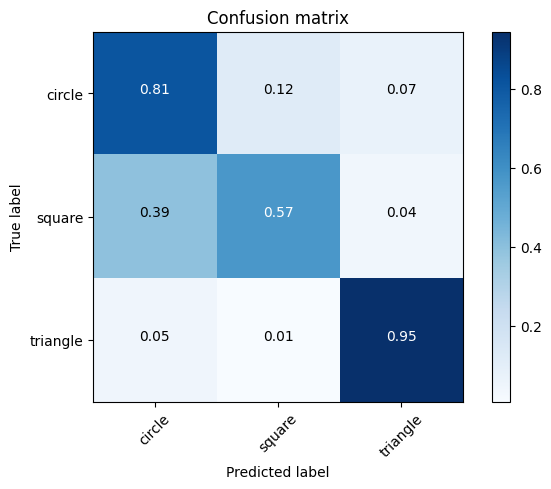

In [27]:
cm = metrics.confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm,['circle', 'square', 'triangle'])

##### Show some predictions

Class mapping: {'circle': 0, 'square': 1, 'triangle': 2}
✅ Loaded 406 test images across 3 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


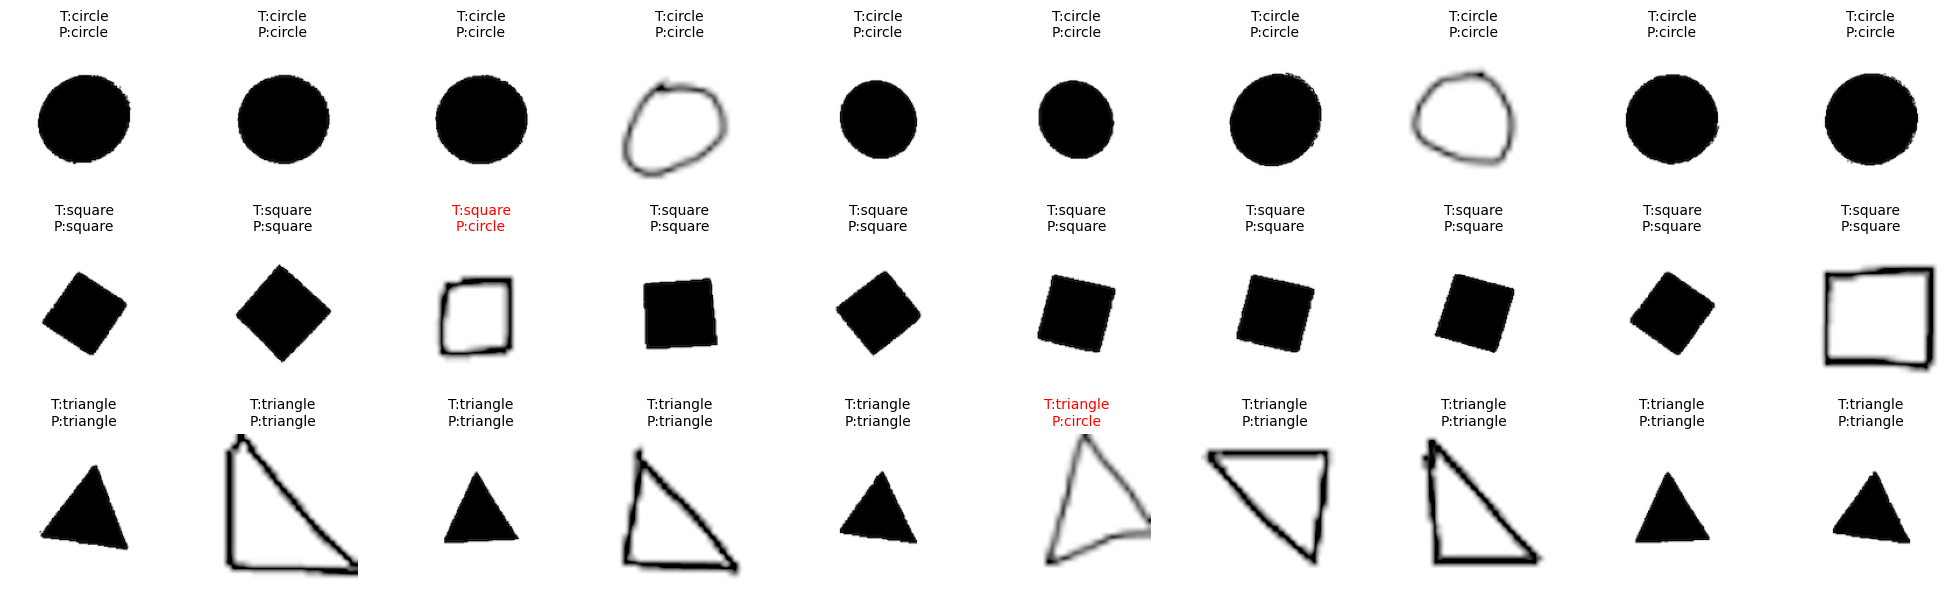

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 1. Get class mapping from the generator (ensures consistency)
class_indices = test_data.class_indices
print("Class mapping:", class_indices)

# Reverse mapping: index → class name
idx_to_class = {v: k for k, v in class_indices.items()}

# 2. Load all test images manually
X_test, y_true, file_paths = [], [], []

for cls, label in class_indices.items():
    cls_dir = os.path.join(test_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.startswith("."):  # skip hidden files like .DS_Store
            continue
        img_path = os.path.join(cls_dir, fname)
        img = image.load_img(img_path, color_mode="grayscale", target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0  # scale to [0,1]
        X_test.append(img_array)
        y_true.append(label)
        file_paths.append(img_path)

X_test = np.array(X_test)
y_true = np.array(y_true)

print(f"✅ Loaded {len(X_test)} test images across {len(class_indices)} classes.")

# 3. Predict with the trained model
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# 4. Display 10 random images per class (row = class, col = sample)
n_per_class = 10
n_classes = len(class_indices)

fig, axes = plt.subplots(n_classes, n_per_class, figsize=(2*n_per_class, 2*n_classes))

# Make sure axes is 2D for consistent indexing
if n_classes == 1:
    axes = np.expand_dims(axes, axis=0)

for class_id, class_name in idx_to_class.items():
    # find all indices of this class
    class_idxs = np.where(y_true == class_id)[0]
    # pick random subset
    chosen = np.random.choice(class_idxs, n_per_class, replace=False)

    for j, idx in enumerate(chosen):
        img = X_test[idx].squeeze()
        true_label = idx_to_class[y_true[idx]]
        pred_label = idx_to_class[y_pred[idx]]

        ax = axes[class_id, j]
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax.axis("off")

        # Red title if misclassified
        color = "black" if y_true[idx] == y_pred[idx] else "red"
        ax.set_title(f"T:{true_label}\nP:{pred_label}", fontsize=10, color=color)

plt.tight_layout()
plt.show()


<div class="rqE">

The model is very good at triangles, but has trouble separating circles from squares. This is expected: in low-resolution grayscale images, circles and squares can appear visually similar (especially if anti-aliased or rotated).

This is actually a great demonstration of why CNNs were invented:
- Dense NN struggle with shapes that differ by local geometry.
- CNN are designed to exploit local patterns (edges, curves, corners), so it should separate circles and squares much better.

**Let's check that in the next subsection, that will start by introducing some key concepts, namely padding, kernel and max pooling**
</div>

### Convolutional Neural Network (CNN)

<div class="intro">

In the previous subsection, we trained a fully connected (dense) neural network on the dataset of geometric shapes.  
The confusion matrix showed that while the model recognized triangles very well, it had difficulty distinguishing circles from squares.  

This limitation is expected, since dense networks treat each pixel independently and do not exploit the spatial structure of images.  
Convolutional Neural Networks (CNNs), on the other hand, are specifically designed to capture local patterns such as edges and curves, which makes them much better suited for image classification tasks.  

In this subsection, we will implement a CNN on the same dataset and compare its performance with that of the dense NN.

</div>

#### Padding, kernel and max pooling

<div class="intro">

This section explains the main parameters used in convolutional layers with **examples of Python code** that you can run in a Jupyter notebook.
</div>


##### Kernel size in convolution

<div class="intro">

**Convolution** is the process of adding each element of the image to its local neighbors, weighted by the **kernel**

The **kernel (or filter)** is a small matrix that slides over the image to detect features (edges, corners, patterns).

- `kernel_size=(3, 3)` → a 3×3 filter.
- `kernel_size=(5, 5)` → a 5×5 filter (captures larger patterns).

**Example:**

We will now see the effect of a vertical efge detection kernel

```python
kernel = np.array([[-1,0,1],
                   [-1,0,1],
                   [-1,0,1]])
```

</div>


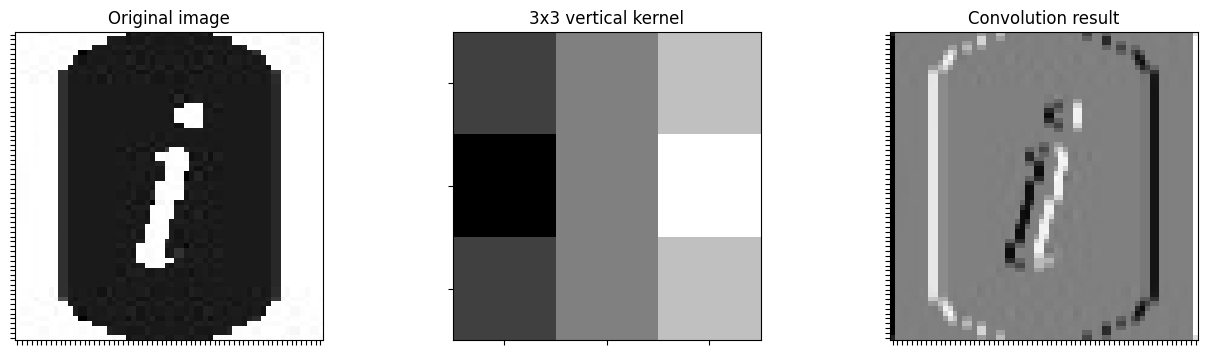

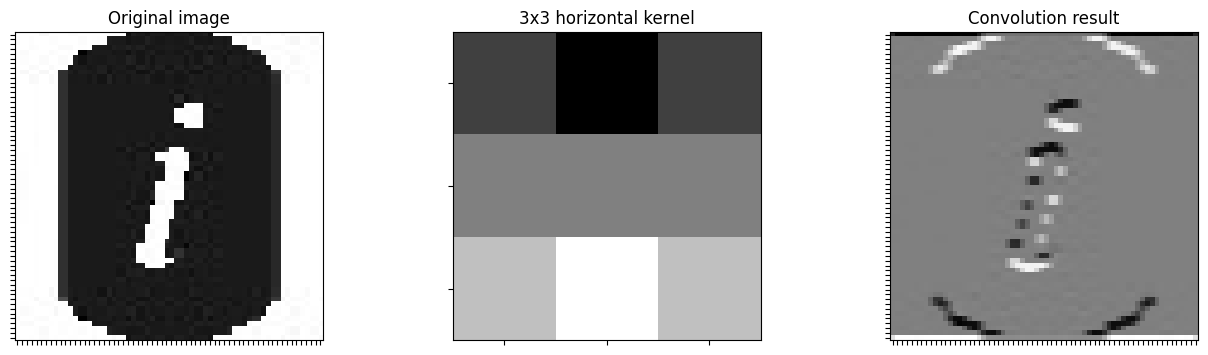

In [28]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt


img_path = "./ML-data/Misc/info-green.jpg"
# Load image, resize to 64x64, convert to grayscale
img = image.load_img(img_path, color_mode="grayscale", target_size=(64, 64))
img_array = image.img_to_array(img).squeeze()   # shape (64,64), values 0–255


def show_with_grid(ax, data, title, vmin=None, vmax=None, grid=False, extent=None):
    """Display a matrix with gridlines and pixel values"""
    ax.imshow(data, cmap="gray", vmin=vmin, vmax=vmax, extent=extent)
    ax.set_title(title)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticks(np.arange(-.5, data.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, data.shape[0], 1), minor=True)
    if grid: ax.grid(which="minor", color="red", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    if grid:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, str(data[i, j]), ha="center", va="center", color="black")

t4pPC.centerTitle("Vertical edge detection")
# 3x3 vertical edge-detection kernel
kernelV = np.array([[-0.5,0,0.5],
                   [-1,0,1],
                   [-0.5,0,0.5]])

conv_img = convolve2d(img_array, kernelV, mode="same")

fig, axes = plt.subplots(1,3, figsize=(16,4))
show_with_grid(axes[0], img_array, "Original image", vmin=0, vmax=255)
show_with_grid(axes[1], kernelV, "3x3 vertical kernel")
show_with_grid(axes[2], conv_img, "Convolution result")
plt.show()


t4pPC.centerTitle("Horizontal edge detection")
# 3x3 horizontal edge-detection kernel
kernelH = np.array([[-0.5,-1,-0.5],
                   [0,0,0],
                   [0.5,1,0.5]])
conv_img = convolve2d(img_array, kernelH, mode="same")

fig, axes = plt.subplots(1,3, figsize=(16,4))
show_with_grid(axes[0], img_array, "Original image", vmin=0, vmax=255)
show_with_grid(axes[1], kernelH, "3x3 horizontal kernel")
show_with_grid(axes[2], conv_img, "Convolution result")
plt.show()

<div class="rqE">

The kernel application isn’t for human visualization — it’s to give the network a mathematical way of detecting edges and other features it can build upon.

- Negative values mark one vertical edge orientation.
- Positive values mark the opposite orientation in terms of brightness.
- Zero means no vertical change.
</div>

##### Padding

<div class="intro">

Let's applay again a kernel, but this time on a smaller image.

- `padding="valid"` → no padding, output is smaller than input.
- `padding="same"` → pads the image with zeros so output has the same size as input.

**Example:**

</div>

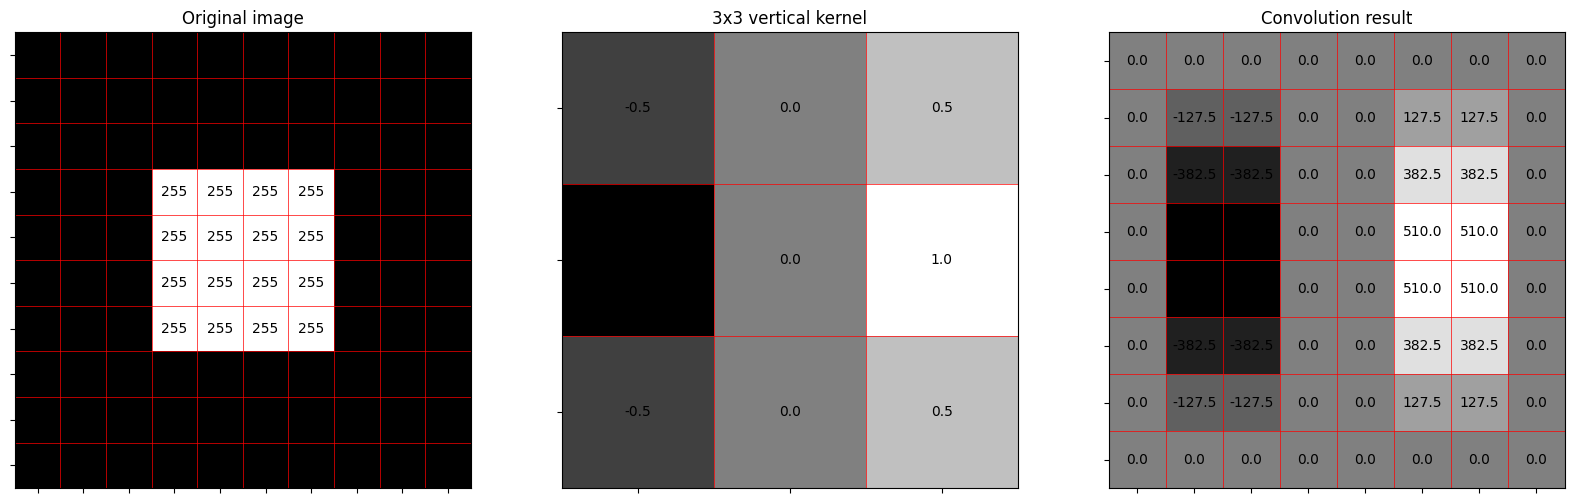

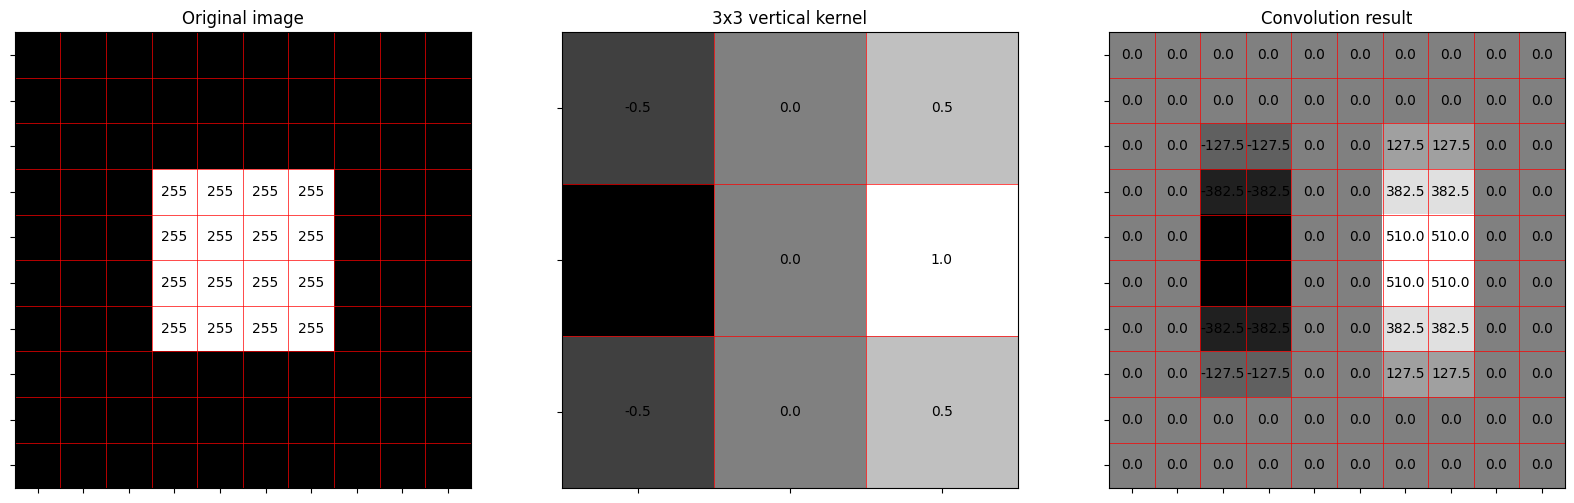

In [29]:
kernelV = np.array([[-0.5,0,0.5],
                   [-1,0,1],
                   [-0.5,0,0.5]])

# Create a 10x10 black image
img = np.zeros((10,10), dtype=int)

# Insert a 4x4 white square in the center
img[3:7, 3:7] = 255   # rows 3–6, cols 3–6

t4pPC.centerTitle("padding='valid'")
conv_img = convolve2d(img, kernelV, mode="valid")

fig, axes = plt.subplots(1,3, figsize=(20,6))
show_with_grid(axes[0], img, "Original image", vmin=0, vmax=255, grid=True)
show_with_grid(axes[1], kernelV, "3x3 vertical kernel", grid=True)
show_with_grid(axes[2], conv_img, "Convolution result", grid=True)
plt.show()

t4pPC.centerTitle("padding='same'")
conv_img = convolve2d(img, kernelV, mode="same")

fig, axes = plt.subplots(1,3, figsize=(20,6))
show_with_grid(axes[0], img, "Original image", vmin=0, vmax=255, grid=True)
show_with_grid(axes[1], kernelV, "3x3 vertical kernel", grid=True)
show_with_grid(axes[2], conv_img, "Convolution result", grid=True)
plt.show()

##### `MaxPooling2D`

<div class="intro">
    
**Pooling** reduces the size of feature maps by taking the maximum value inside each small window.

- `MaxPool2D((2,2))` → splits the image into 2×2 regions and keeps only the maximum pixel in each.

**Example:**
Pooling keeps the **strongest activations**, reduces the size, and helps the network focus on important features.

</div>

In [30]:
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Input, Model
import numpy as np

data = np.array([[1,2,3,4],
                 [5,6,7,8],
                 [9,10,11,12],
                 [13,14,15,16]]).reshape(1,4,4,1)

inp = Input(shape=(4,4,1))
out = MaxPool2D((2,2))(inp)
pool_model = Model(inp, out)

result = pool_model.predict(data)
print("Original 4x4 image:\n", data[0,:,:,0])
print("After 2x2 max pooling:\n", result[0,:,:,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Original 4x4 image:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
After 2x2 max pooling:
 [[ 6.  8.]
 [14. 16.]]


<div class="intro">

Let's apply it the the 48x48 "info" icon image
</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Original image shape: (1, 48, 48, 1)
After pooling original: (24, 24)


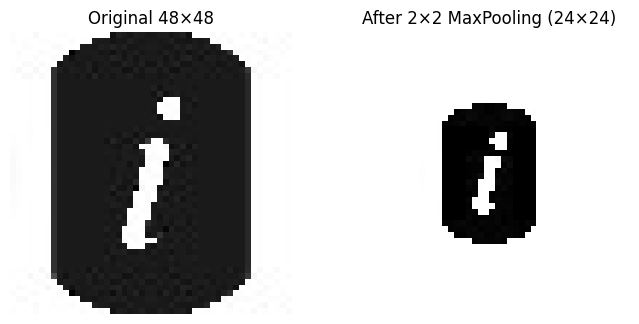

In [31]:
# --- Load your image ---
img_path = "./ML-data/Misc/info-green.jpg"
img = image.load_img(img_path, color_mode="grayscale", target_size=(48, 48))
img_array = image.img_to_array(img).squeeze()   # shape (48,48), values 0–255

# Reshape to (1, 48, 48, 1) for Keras
img_input = img_array.reshape(1,48,48,1)

# --- Define a simple model with max pooling ---
inp = Input(shape=(48,48,1))
out = MaxPool2D((2,2))(inp)   # 2x2 pooling
pool_model = Model(inp, out)

# --- Apply pooling directly to the original image ---
pooled_original = pool_model.predict(img_input)
pooled_original = np.squeeze(pooled_original)   # now shape is (24,24)

print("Original image shape:", img_input.shape)
print("After pooling original:", pooled_original.shape)

# --- Show results ---

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(img_array, cmap="gray")
axes[0].set_title("Original 48×48")
axes[0].axis("off")

axes[1].imshow(pooled_original, cmap="gray", extent=[12,36,12,36])
axes[1].set_title("After 2×2 MaxPooling (24×24)")
axes[1].set_xlim(0,48)
axes[1].set_ylim(0,48)
axes[1].axis("off")

plt.show()


#### Model construction

<div class="intro">

This code defines, compiles, and visualizes a Convolutional Neural Network (CNN) in Keras to classify grayscale images of size **128×128** into **three classes** (circle, square, triangle).

---

1. **Resetting Keras state**

```python
tf.keras.backend.clear_session()
```

Clears any previous models or layers from memory to avoid conflicts.

---

2. **Input layer**

```python
input = Input(shape=(128, 128, 1))
```

Defines the input shape: 128×128 pixels with 1 channel only, since it's grayscale images, and not rgb.

---

3. **First convolutional block**

```python
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(input)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Dropout(0.3)(x)
```

- `Conv2D`: 16 filters of size 3×3, ReLU activation, keeps image size (`padding='same'`).  
- `MaxPool2D`: reduces the spatial size by a factor of 2.  
- `Dropout(0.3)`: randomly drops 30% of activations during training (regularization).

---

4. **Second convolutional block**

```python
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Dropout(0.3)(x)
```

Another convolution → pooling → dropout sequence, extracting higher-level features.

---

5. **Fully connected layers**

```python
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)
```

- `Flatten`: converts 2D feature maps into a 1D vector.  
- `Dense(32, relu)`: fully connected hidden layer.  
- `Dropout(0.2)`: 20% dropout to reduce overfitting.  
- `Dense(3, softmax)`: output layer with 3 neurons (one per class), producing class probabilities.

---

6. **Model compilation**

```python
optimizer = 'adam'
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])
```

- Loss: categorical crossentropy (standard for multi-class classification).  
- Optimizer: Adam (adaptive gradient optimizer).  
- Metric: accuracy.

---

7. **Model summary and visualization**

```python
model.summary()
fig = plot_model(model, dpi=300, show_dtype=True, 
                 show_shapes=True, show_layer_names=True, 
                 show_layer_activations=True)
t4pPC.displayModel(fig, width=600)
```

- `model.summary()`: text summary of layers, shapes, and parameters.  
- `plot_model`: generates a visual diagram of the network (with shapes, activations, and data types).  
- `t4pPC.displayModel`: custom function to display the model diagram nicely in the notebook.

---

**In summary:**  
This code builds a simple CNN with two convolutional blocks followed by a small dense classifier. It is regularized with dropout layers, trained with Adam optimizer, and designed to classify grayscale images into three categories.


</div>

/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,899 (2.01 MB)

 Trainable params: 526,899 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

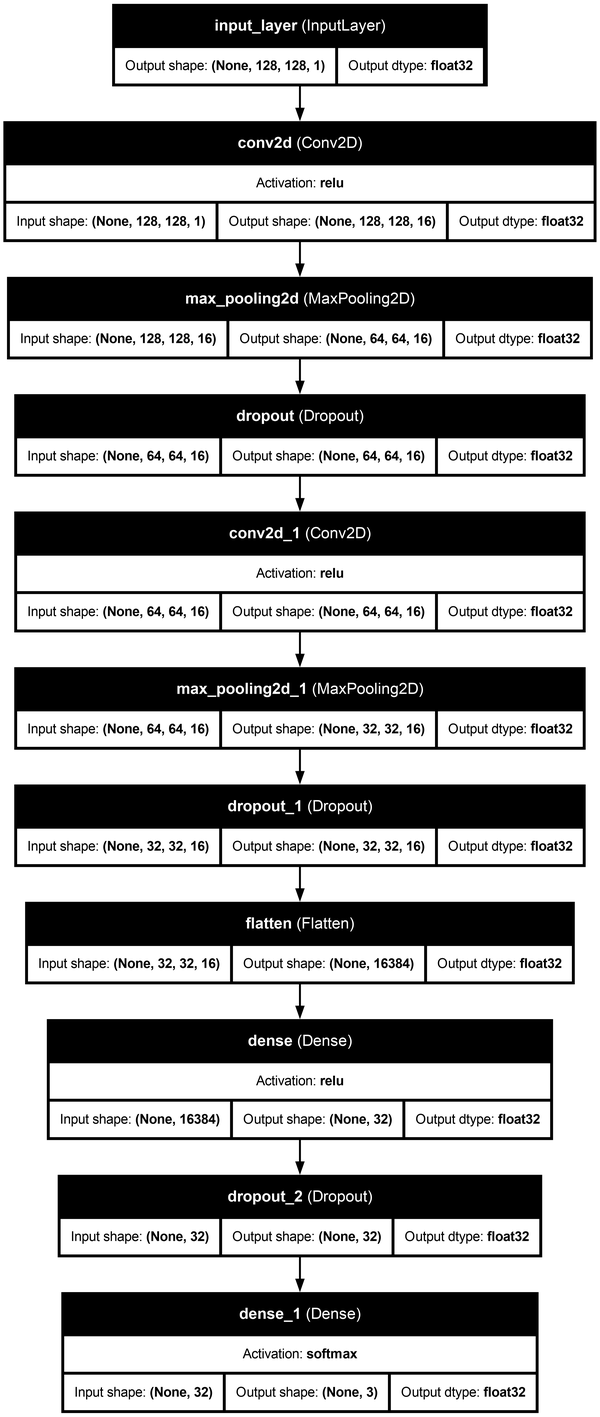

In [32]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Input, Model
import numpy as np

from keras import models
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


# Resets all state generated by Keras
tf.keras.backend.clear_session()

input = Input(shape=(128, 128, 1))

x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(128, 128, 1))(input)

x = layers.MaxPool2D((2, 2))(x)
x = layers.Dropout(0.3)(x)


x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding = 'same')(x)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)

model = models.Model(input, x)

#from tensorflow.keras.optimizers import SGD
#optimizer = SGD(learning_rate=0.1)
optimizer = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
model.summary()

from tensorflow.keras.utils import plot_model
fig = plot_model(model, dpi=300, show_dtype=True , show_shapes=True, show_layer_names=True, show_layer_activations=True)
t4pPC.displayModel(fig, width = 600)

#### Run for 40 Epochs maximum

In [33]:
nepochs = 40

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',    # you can also use 'val_accuracy'
    patience=5,            # number of epochs with no improvement before stopping
    restore_best_weights=True # roll back to the best model
)

# Train the model with early stopping
history = model.fit(
    training_data,
    validation_data=val_data,
    epochs=nepochs,
    callbacks=[early_stop]
)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5117 - loss: 1.0308 - val_accuracy: 0.6034 - val_loss: 0.8820
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6848 - loss: 0.7171 - val_accuracy: 0.7759 - val_loss: 0.5706
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7486 - loss: 0.5680 - val_accuracy: 0.7980 - val_loss: 0.4794
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7870 - loss: 0.4718 - val_accuracy: 0.8128 - val_loss: 0.4150
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8165 - loss: 0.4189 - val_accuracy: 0.8177 - val_loss: 0.3717
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8314 - loss: 0.3666 - val_accuracy: 0.8498 - val_loss: 0.3562
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8539 - loss: 0.3204 - val_accuracy: 0.8350 - val_loss: 0.3631
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8708 - loss: 0.2830 - val_accuracy: 0.8744 - v

#### Analysis of the Results 

In [34]:
accuracy = history.history['accuracy'][1:]
loss = history.history['loss'][1:]
val_accuracy = history.history['val_accuracy'][1:]
val_loss = history.history['val_loss'][1:]

##### Plot Accuracy and Validation Accuracy curve

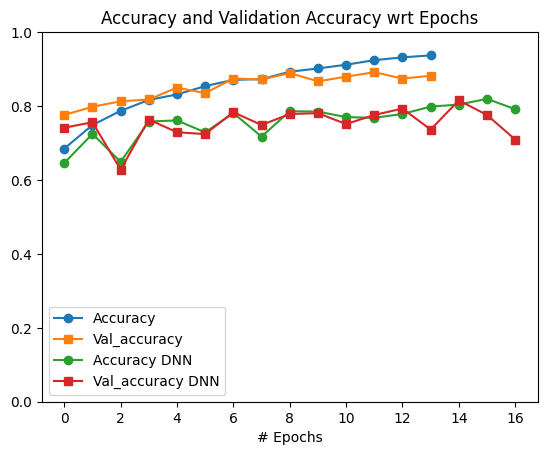

In [35]:
#plot accuracy for model
plt.plot(range(len(accuracy)), accuracy, marker= 'o', label = 'Accuracy')
#plot loss for model
plt.plot(range(len(val_accuracy)), val_accuracy, marker= 's', label = 'Val_accuracy')
plt.plot(range(len(accuracyDNN)), accuracyDNN, marker= 'o', label = 'Accuracy DNN')
plt.plot(range(len(val_accuracyDNN)), val_accuracyDNN, marker= 's', label = 'Val_accuracy DNN')
plt.xlabel('# Epochs')
plt.ylim(0.0,1.00)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
plt.ylabel('')
plt.title('Accuracy and Validation Accuracy wrt Epochs')
plt.legend()

##### Plot Loss and and Validation_loss 

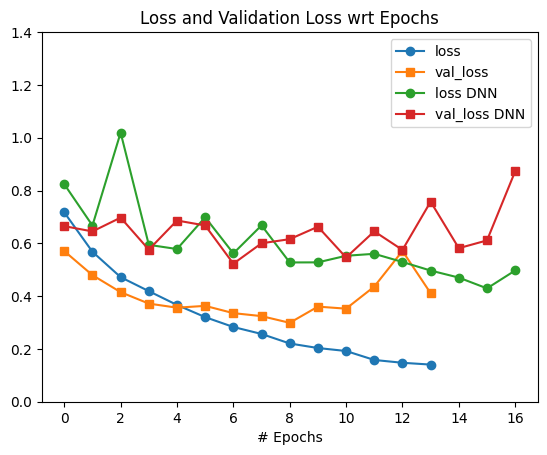

In [36]:
plt.plot(range(len(loss)), loss, marker= 'o', label = 'loss')
#plot loss for model
plt.plot(range(len(val_loss)), val_loss, marker= 's', label = 'val_loss')
plt.plot(range(len(lossDNN)), lossDNN, marker= 'o', label = 'loss DNN')
plt.plot(range(len(val_lossDNN)), val_lossDNN, marker= 's', label = 'val_loss DNN')
plt.xlabel('# Epochs')
plt.ylabel('')
plt.ylim(0.0,1.4)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
plt.title('Loss and Validation Loss wrt Epochs')
plt.legend()

#### Test the Model

##### Prediction

In [37]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
print(class_labels)
print(true_classes)
#test_data
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

['circle', 'square', 'triangle']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

##### Confusion matrix

Normalized confusion matrix
[[0.82677165 0.08661417 0.08661417]
 [0.06923077 0.87692308 0.05384615]
 [0.01342282 0.03355705 0.95302013]]


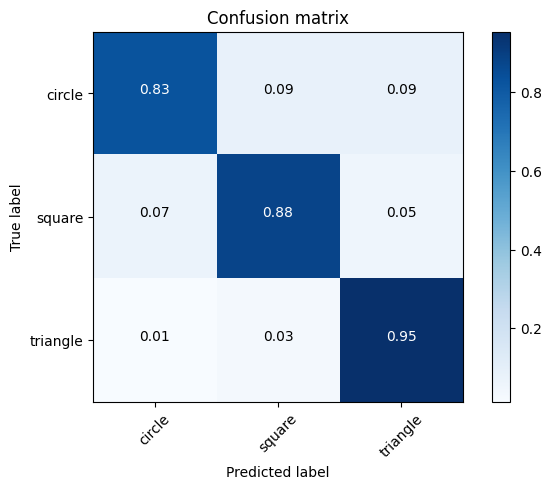

In [40]:
cm = metrics.confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm,['circle', 'square', 'triangle'])

#### Visualization of some shapes of the training set

Class mapping: {'circle': 0, 'square': 1, 'triangle': 2}
✅ Loaded 406 test images across 3 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


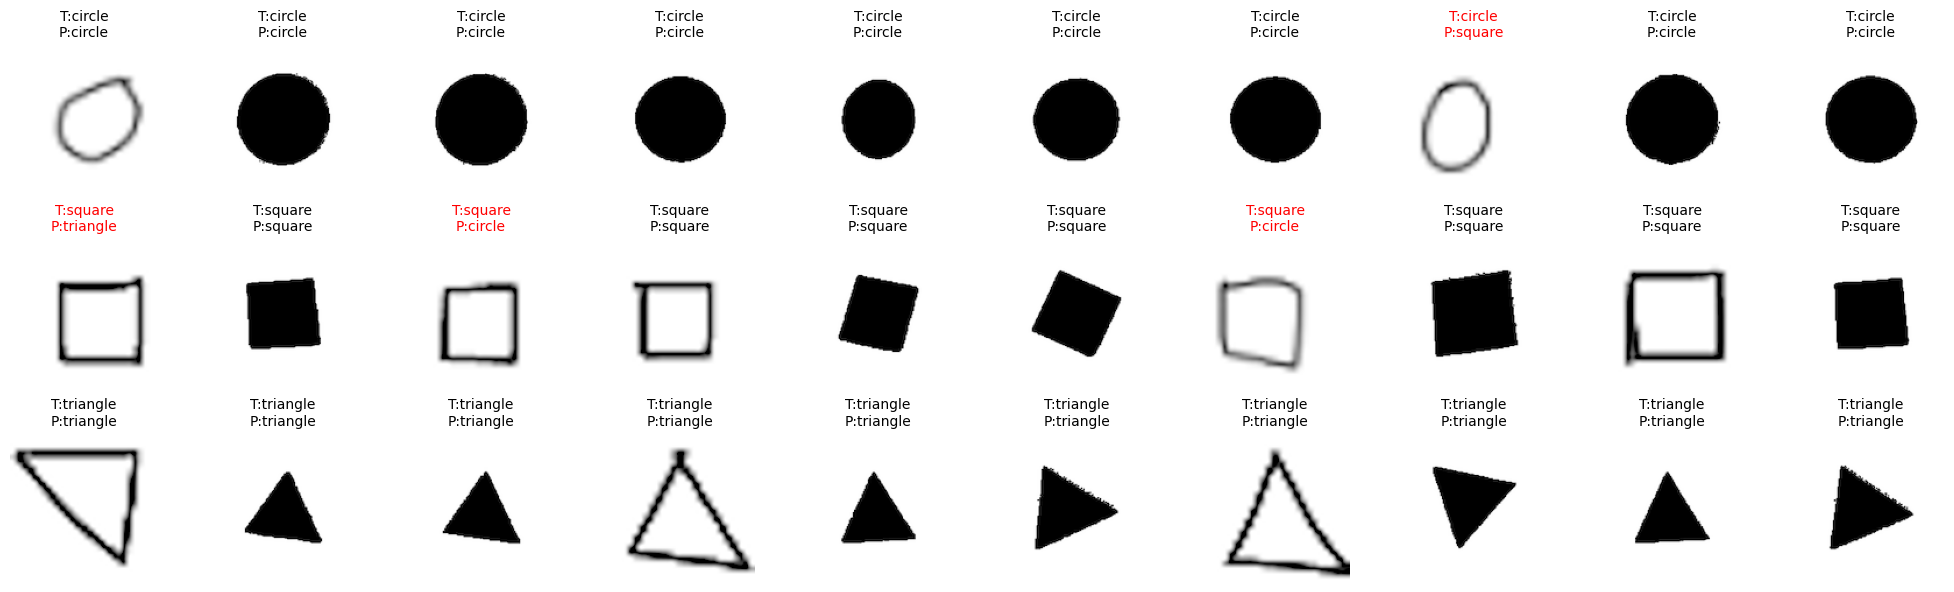

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 1. Get class mapping from the generator (ensures consistency)
class_indices = test_data.class_indices
print("Class mapping:", class_indices)

# Reverse mapping: index → class name
idx_to_class = {v: k for k, v in class_indices.items()}

# 2. Load all test images manually
X_test, y_true, file_paths = [], [], []

for cls, label in class_indices.items():
    cls_dir = os.path.join(test_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.startswith("."):  # skip hidden files like .DS_Store
            continue
        img_path = os.path.join(cls_dir, fname)
        img = image.load_img(img_path, color_mode="grayscale", target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0  # scale to [0,1]
        X_test.append(img_array)
        y_true.append(label)
        file_paths.append(img_path)

X_test = np.array(X_test)
y_true = np.array(y_true)

print(f"✅ Loaded {len(X_test)} test images across {len(class_indices)} classes.")

# 3. Predict with the trained model
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

n_per_class = 10
n_classes = len(class_indices)

fig, axes = plt.subplots(n_classes, n_per_class, figsize=(2*n_per_class, 2*n_classes))

# Make sure axes is 2D for consistent indexing
if n_classes == 1:
    axes = np.expand_dims(axes, axis=0)

for class_id, class_name in idx_to_class.items():
    # find all indices of this class
    class_idxs = np.where(y_true == class_id)[0]
    # pick random subset
    chosen = np.random.choice(class_idxs, n_per_class, replace=False)

    for j, idx in enumerate(chosen):
        img = X_test[idx].squeeze()
        true_label = idx_to_class[y_true[idx]]
        pred_label = idx_to_class[y_pred[idx]]

        ax = axes[class_id, j]
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax.axis("off")

        # Red title if misclassified
        color = "black" if y_true[idx] == y_pred[idx] else "red"
        ax.set_title(f"T:{true_label}\nP:{pred_label}", fontsize=10, color=color)

plt.tight_layout()
plt.show()

#### SHAP analysis

<div class="rqE">

See also the [sandbox notebook](./Sandbox.ipynb), with SHAP applied to the MNIST large database of handwritten digits.
</div>

In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import shap
import cv2

class ShapVisualizer:
    """
    Visualize SHAP values for CNN models on image data.

    This class overlays SHAP attribution maps on grayscale images 
    and displays, for each sample and each class:
    - the original image,
    - the SHAP heatmap,
    - the predicted probability,
    - the additive decomposition (base value + sum of SHAP, and reconstructed value).

    Parameters
    ----------
    model : keras.Model
        Trained Keras model with softmax output.
    explainer : shap.DeepExplainer
        SHAP explainer fitted on a background dataset.
    x_explain : np.ndarray
        Images to explain, shape (n_samples, H, W, 1).
    idx_to_class : dict, optional
        Mapping from class indices to human-readable class labels 
        (e.g. {0: "circle", 1: "square"}). If None, numerical IDs are shown.
    y_true : np.ndarray, optional
        Ground-truth labels of the explained images (shape (n_samples,)), 
        expressed as integer class indices. If provided together with 
        `idx_to_class`, the original image column will display the true label.
    downsample_factor : int, default=1
        Factor by which SHAP maps are downsampled for visualization. 
        For example, 4 means a 128×128 SHAP map is reduced to 32×32 blocks 
        and then upscaled back to 128×128. If 1, no downsampling is applied.
    scale : {"max", "robust", "percentile"}, default="max"
        How to scale SHAP colormap:
        - "max" → use global maximum of |SHAP values|.
        - "robust" → use median + 3*MAD.
        - "percentile" → use 99th percentile of |SHAP values|.

    Attributes
    ----------
    shap_values : np.ndarray
        SHAP values of shape (n_samples, H, W, 1, n_classes).
    probs : np.ndarray
        Model predicted probabilities, shape (n_samples, n_classes).
    pred_classes : np.ndarray
        Indices of predicted classes, shape (n_samples,).
    n_samples : int
        Number of explained images.
    n_classes : int
        Number of output classes.
    shap_cmap : matplotlib.colors.LinearSegmentedColormap
        Custom colormap used for SHAP visualization (blue → white → red).
    """

    def __init__(self, model, explainer, x_explain, idx_to_class=None, y_true=None, downsample_factor=1.0, scale="max"):
        self.model = model
        self.explainer = explainer
        self.x_explain = x_explain
        self.idx_to_class = idx_to_class  # optional mapping index→label
        self.y_true = y_true  # optional ground truth labels
        self.downsample_factor = downsample_factor
        self.scale = scale

        # Compute SHAP values, predictions, classes
        self.shap_values = explainer.shap_values(x_explain)
        self.probs = model.predict(x_explain, verbose=0)
        self.pred_classes = np.argmax(self.probs, axis=1)

        # Dimensions
        self.n_samples = x_explain.shape[0]
        self.n_classes = self.probs.shape[1]
        
        # Detect if explainer provides expected_value
        self.has_expected_value = hasattr(explainer, "expected_value")
        
        # Define SHAP colormap (blue → white → red)
        self.shap_cmap = mcolors.LinearSegmentedColormap.from_list(
            "shap",
            ["#1e88e5", "white", "#b6093e"]
        )


    def _compute_scale(self):
        vals = np.abs(self.shap_values).ravel()
        if self.scale == "robust":
            med = np.median(vals)
            mad = np.median(np.abs(vals - med))
            m = med + 3 * mad
        elif self.scale == "percentile":
            m = np.percentile(vals, 99)
        else:  # default "max"
            m = np.max(vals)
        return m
        
    def _downsample(self, sv):
        """Downsample SHAP map if factor > 1, else return unchanged."""
        if self.downsample_factor == 1:
            return sv
        h, w = sv.shape
        small = cv2.resize(
            sv, 
            (w // self.downsample_factor, h // self.downsample_factor),
            interpolation=cv2.INTER_AREA
        )
        upscaled = cv2.resize(
            small, (w, h),
            interpolation=cv2.INTER_NEAREST
        )
        return upscaled
        
    def plot(self):
        """Plot SHAP overlays for the explained images."""
        m = self._compute_scale()  # global symmetric scale
        print(f"{m=}")

        fig, axes = plt.subplots(
            self.n_samples, self.n_classes+1,
            figsize=(2*(self.n_classes+1), 2*self.n_samples),
            dpi=96
        )

        for i in range(self.n_samples):  # each row = one image
            # First column: original image + true label if available
            _ = axes[i, 0].imshow(self.x_explain[i].squeeze(), cmap="gray")
            _ = axes[i, 0].axis("off")
            if self.y_true is not None and self.idx_to_class is not None:
                true_label = self.idx_to_class[self.y_true[i]]
                _ = axes[i, 0].set_title(f"{true_label}")
            elif i == 0:
                _ = axes[i, 0].set_title("")

            # Columns: SHAP heatmaps
            for j in range(self.n_classes):
                sv = self.shap_values[i, :, :, 0, j]
                sv = self._downsample(sv)
                
                _ = axes[i, j+1].imshow(self.x_explain[i].squeeze(), cmap="gray")
                im = axes[i, j+1].imshow(
                    sv, cmap=self.shap_cmap, alpha=0.7, vmin=-m, vmax=+m,
                    interpolation="bilinear"
                )
                _ = axes[i, j+1].axis("off")

                # Probability and decomposition
                prob = self.probs[i, j]
                sv_sum = sv.sum()

                # Handle expected_value only if available
                if self.has_expected_value:
                    base_val = self.explainer.expected_value[j]
                else:
                    base_val = 0.0  # fallback for GradientExplainer etc.
                reconstructed = base_val + sv_sum

                # Title: class + probability
                label = self.idx_to_class[j] if self.idx_to_class else j
                title = f"{label}\n{prob:.2f}"
                if j == self.pred_classes[i]:
                    _ = axes[i, j+1].set_title(
                        title, color="darkred", fontweight="bold"
                    )
                else:
                    _ = axes[i, j+1].set_title(title)

                # Bottom text: base + SHAP sum (+ reconstructed if relevant)
                if self.has_expected_value:
                    text = f"bv={base_val:.2f}, s={sv_sum:.2f}"
                else:
                    text = f"s={sv_sum:.2f}"  # no base value available
                _ = axes[i, j+1].text(
                    0.5, -0.05, text,
                    fontsize=9, ha="center", va="top",
                    transform=axes[i, j+1].transAxes
                )

        # Shared colorbar
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax, orientation="vertical", label="SHAP value")

        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.show()


<div class="intro">

SHAP needs a baseline reference, called the **background**. We will now build the background dataset for SHAP’s DeepExplainer.

The SHAP values for a given image are defined relative to this baseline - for each sample and each class, it is called a **base value**. If the background is biased (e.g., only circles), the attributions won’t be reliable.

So here, we’re sampling an equal number of images from each training class to get a balanced baseline.
</div>

In [54]:
import os
from tensorflow.keras.preprocessing import image

n_per_class_bg = 100  # approximately 300 images in total, i.e. 100 per class

X_bg = []

for class_name in training_data.class_indices.keys():
    cls_dir = os.path.join(train_dir, class_name)
    all_files = [f for f in os.listdir(cls_dir) if not f.startswith(".")]
    chosen_files = np.random.choice(all_files, n_per_class_bg, replace=False)

    for fname in chosen_files:
        img_path = os.path.join(cls_dir, fname)
        img = image.load_img(img_path, color_mode="grayscale", target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0
        X_bg.append(img_array)

background = np.array(X_bg)
print("Background shape:", background.shape)

# Build the explainer on balanced background
# explainer = shap.DeepExplainer(model, background)
explainer = shap.GradientExplainer(model, background)

Background shape: (300, 128, 128, 1)


{0: 'circle', 1: 'square', 2: 'triangle'}
✅ Selected 6 images: 2 per class.
m=np.float64(0.0014742795261554428)


/tmp/ipykernel_13378/3579703030.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


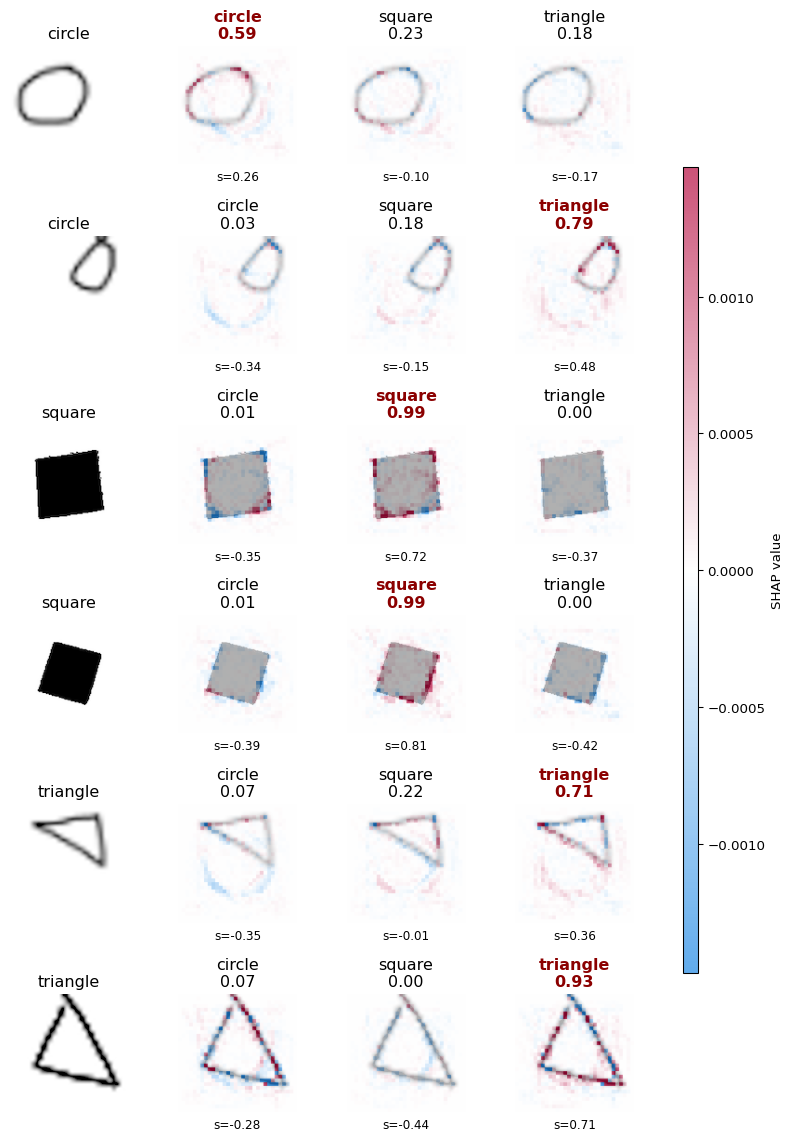

In [55]:
import os
from tensorflow.keras.preprocessing import image

# Number of examples per class
n_per_class = 2  

# Get class mapping
class_indices = test_data.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print(idx_to_class)


# Collect images per class
X_explain, y_explain = [], []

for class_id, class_name in idx_to_class.items():
    cls_dir = os.path.join(test_dir, class_name)
    all_files = [f for f in os.listdir(cls_dir) if not f.startswith(".")]

    # Randomly sample n_per_class from this folder
    chosen_files = np.random.choice(all_files, n_per_class, replace=False)

    for fname in chosen_files:
        img_path = os.path.join(cls_dir, fname)
        img = image.load_img(img_path, color_mode="grayscale", target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0
        X_explain.append(img_array)
        y_explain.append(class_id)

X_explain = np.array(X_explain)
y_explain = np.array(y_explain)

print(f"✅ Selected {len(X_explain)} images: {n_per_class} per class.")

# Get mapping from generator
# Visualize
visu = ShapVisualizer(
    model, explainer,
    X_explain,
    idx_to_class=idx_to_class,
    y_true=y_explain,
    downsample_factor=4,
    scale='percentile'
)
visu.plot()

#### Can you do better ?

<div class="exE">

Ask ChatGPT or any other large language model.
</div>

In [ ]:
# enter your code here


<div class="sol">

Want to see a possible answer from ChatGPT? Uncomment the `# from IPython.display import Markdown, display;...` command below, and then run the cell twice (one to load a mardown text, the second one to run it)

Read carefully the suggestions and then correct your code.

You can also uncomment the `# %load ./SolutionsToExercises/...` command in the solution cell right after the next one, and then run it twice as well (once to load the python code, and once more to run it)

</div>

In [ ]:
# from IPython.display import Markdown, display; display(Markdown(open("SolutionsToExercises/ML/CNN_model_shapes_analysis.md").read()))

In [ ]:
# %load ./SolutionsToExercises/ML/CNN_model_shapes_analysis.py
# after "ChatGPT 5.0 instant" answer, 2025-09-28

<div class="rqT" title="Not bad!">

If ChatGPT’s advice has been helpful and relevant, as its 5.0 version was in September 2025, you’ve significantly improved the accuracy of your new model.
</div>

# Useful links

[Convolution article on Wikipedia](https://en.wikipedia.org/wiki/Convolution)

[Hands-on machine learning with scikit-learn, keras and tensorflow (3rd edition, **2022**), Aurélien Géron, O'Reilly editions](https://github.com/ageron/handson-ml3)

Some images were generated with [DALL·E](https://openai.com/dall-e-2)

[What is convolution? (YT video)](https://www.youtube.com/watch?v=KuXjwB4LzSA)

# End

In [ ]:
vID.end(cwd0)

# Appendix: additional functions

## Salt and pepper

In [ ]:
def add_SaltPepperNoise(img, ratio=10, CornSize = 3, SaltAndPepper="SaltAndPepper",show=True): 
    import random
    import matplotlib.pyplot as plt
    import numpy as np
    # Getting the dimensions of the image 
    row , col = img.shape 
    imgNew = img.copy()

    npix = row*col
    print(f"Image = {row} pixels x {col} pixels = {npix} pixels")
    number_of_pixels = npix*ratio//100 
    print(f"Number of random black/white pixels = {number_of_pixels}")
    shift = CornSize//2
    if SaltAndPepper == 'SaltAndPepper' or SaltAndPepper == 'Salt':
        # Randomly pick some pixels in the image for coloring them white
        for i in range(number_of_pixels): 
            yrow=random.randint(0, row - 1) 
            xcol=random.randint(0, col - 1)
            for y in range(yrow-shift,yrow+shift):
                for x in range(xcol-shift,xcol+shift):
                    yR = max(min(y,0),min(y,row-1))
                    xR = max(min(x,0),min(x,col-1))
                    imgNew[yR][xR] = 1.
    if SaltAndPepper == 'SaltAndPepper' or SaltAndPepper == 'Pepper':
        # Randomly pick some pixels in the image for coloring them black 
        for i in range(number_of_pixels): 
            yrow=random.randint(0, row - 1) 
            xcol=random.randint(0, col - 1) 
            for y in range(yrow-shift,yrow+shift):
                for x in range(xcol-shift,xcol+shift):
                    yR = max(min(y,0),min(y,row-1))
                    xR = max(min(x,0),min(x,col-1))
                    imgNew[yR][xR] = 0.
    if show:
        plotimgs_SideBySide([img,imgNew], imgW=8, titles=["Original image", "Salt and Pepper version"], histogram=True)
    return imgNew

from matplotlib import pyplot as plt
from skimage.color import rgb2gray
img = plt.imread('./ML-Figures/bouquinistes/bouquinistes.jpg')
img = rgb2gray(img)
img.shape
imgPepper = add_SaltPepperNoise(img, 1, 7, SaltAndPepper="Pepper")
plt.imsave('./ML-Figures/bouquinistes/bouquinistesPepper.jpg', imgPepper, cmap="gray")

## Sobel filter

<div class="intro">
    
The Sobel operator, sometimes called the Sobel–Feldman operator or Sobel filter, is used in image processing and computer vision, particularly within edge detection algorithms where it creates an image emphasising edges
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.color import rgb2gray
    
Sobel = np.array([-1, -2, -1,0,0,0,1,2,1])
Sobel=Sobel.reshape(3,3)
print(Sobel)

imgT = plt.imread('./ML-Figures/bouquinistes/bouquinistesTorned.jpg')
# imgT = plt.imread('./ML-Figures/bouquinistes/bouquinistesPepper.jpg')
imgTGray = rgb2gray(imgT)
contourT = convolve(imgTGray,Sobel,mode='reflect')
plotimgs_SideBySide([imgTGray, contourT],imgW=10,titles=["original image","Sobel filtering"])

imgTWM =  plt.imread('./ML-Figures/bouquinistes/bouquinistesTornedWithMask.jpg')
# imgTWM =  plt.imread('./ML-Figures/bouquinistes/bouquinistesPepper.jpg')
imgTWMGray = rgb2gray(imgTWM)
contourTWM = convolve(imgTWMGray,Sobel,mode='reflect')
plotimgs_SideBySide([imgTWMGray, contourTWM],imgW=10,titles=["original image with black mask","Sobel filtering"])
